# **Day-ahead Banknifty/Nifty Forecasting**

#### Input - 15 mins candle data
#### Output - Forcast of 1 day of 15 mins close price  

Special Notes:
 - Don't open CSV file and change dateformat, it will change the format entirely and cause problem in code
 - Output of Model changed if we dont delete NaN values (I saw that when comparing jupyter file with normal python file matching)

## Define stock for which ML model needs to be prepared

In [1]:
# Get data from Python file--------------
import json

# Load the arguments
with open('arguments.json', 'r') as fid:
    arguments = json.load(fid)

stock = arguments['ticker']
print(stock)


#stock = "SUNPHARMA"

FINNIFTY


In [2]:
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset
import math
import pickle # Saving the final model
import time
import datetime as dt

##############
# Dependencies
##############
import json
import requests
import numpy as np
import pandas as pd
import os, time, math
from datetime import *
os.environ['TZ'] = 'Asia/Calcutta'
from sqlalchemy import create_engine
from scipy.signal import savgol_filter
pd.options.mode.chained_assignment = None





##################
# Visualizations
#################
import seaborn as sns
#import plotly.offline
#import cufflinks as cf
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams



##################
# Display Changes
##################
# cf.go_offline()
%matplotlib inline
rc('axes', linewidth=2)
rc('font', weight='bold')
sns.set_style('whitegrid')
#pd.set_option('max_rows',2000)
#pd.set_option('max_columns',255) 
rcParams['figure.figsize'] = 15,5
#cf.set_config_file(offline=False, world_readable=True)


##############
# Modeling
##############
# import xgboost as xgb
# from xgboost import plot_importance
from sklearn import preprocessing, svm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# ##################
# # Display Changes
# ##################
# from matplotlib import rc, rcParams
# pd.options.mode.chained_assignment = None
# # cf.go_offline()
# %matplotlib inline
# rc('axes', linewidth=2)
# #rc('font', weight='bold')

# #pd.set_option('max_rows', 1000)
# pd.set_option('display.max_rows', None)
# pd.set_option('max_columns', 255)
# # Useful line of code to set the display option so we could see all the columns in pd dataframe
# #pd.set_option('display.max_columns', None)

# #rcParams['figure.figsize'] = 8,3
# # cf.set_config_file(offline=False, world_readable=True)

# rc('xtick', labelsize=9) 
# rc('ytick', labelsize=9)
# #rc('axes', linewidth=2)
# rc('axes', titlesize=10)


# # Matplot Theme setting
# from matplotlib import cycler
# colors = cycler('color',
#                 ['#EE6666', '#3388BB', '#9988DD',
#                  '#EECC55', '#88BB44', '#FFBBBB'])
# rc('axes', facecolor='#E6E6E6', edgecolor='none', axisbelow=True, grid=True, prop_cycle=colors)
# rc('grid', color='w', linestyle='solid')
# rc('xtick', direction='out', color='black')
# rc('ytick', direction='out', color='black')
# rc('patch', edgecolor='#E6E6E6')
# rc('lines', linewidth=1)

In [4]:
# Seaborn
rc = {
    "axes.facecolor": "#FAEEE9",
    "figure.facecolor": "#FAEEE9",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "calibri",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.9
}
sns.set(rc=rc)
sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 1})


#sns.set_style('whitegrid')

In [5]:
datetime.now()

datetime.datetime(2024, 2, 1, 6, 49, 27, 566386)

## Prevent plot from showing

In [6]:
#plt.ioff()

## Analysis

In [7]:
# I have make the function for Doing quick basic analysis as per given DataFrame

def analysis(df):
    
    print('#############################################################')
    print(f'Shape of DF = {df.shape}\n')
    print('--------------------------------------------------')
    print(f'First 5 rows are as following \n {df.head()} \n')
    print('--------------------------------------------------')
    print(f'Basic info as following \n {df.info()} \n')
    print('--------------------------------------------------')
  
    if 'datetime' in df.columns:
        print(f"\n We have data from {pd.to_datetime(df['datetime']).min()}")
        print(f" We have data till {pd.to_datetime(df['datetime']).max()}")
    print('--------------------------------------------------')
    print(f'\n Basic description as following \n')
    print(df.describe())
    print('--------------------------------------------------')
    print(f'\n Missing values are as following \n')
    print(df.isnull().sum())
    print('##############################################################')

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')
# folder_path = '/content/drive/MyDrive/Climate_Connect/IEX/01_Data_Tuesday_Forecast'

In [9]:
# As its difficult to upload files again and again, so I change code to access drive files. 

#df = pd.read_parquet('./Data/historical_load_data.parquet')
#df = pd.read_excel(f'{folder_path}/DAM_multivariate_data.xlsx')


df = pd.read_csv(f'01_Data\data_{stock}.csv')
df.head()

,datetime,open,high,low,close,volume,date
0,2021-01-01 09:15:00,15215.40,15282.45,15198.20,15265.05,0,NaN
1,2021-01-01 10:15:00,15264.65,15266.40,15224.60,15228.65,0,NaN
2,2021-01-01 11:15:00,15227.95,15239.90,15189.65,15214.00,0,NaN
3,2021-01-01 12:15:00,15213.65,15235.75,15205.65,15220.35,0,NaN
4,2021-01-01 13:15:00,15218.05,15238.30,15194.75,15232.25,0,NaN


### Only retain "Close" & "Volume"

In [10]:
drop_col = ['open', 'high', 'low', 'volume', 'date']
df = df.drop(drop_col, axis=1)
df.head()

,datetime,close
0,2021-01-01 09:15:00,15265.05
1,2021-01-01 10:15:00,15228.65
2,2021-01-01 11:15:00,15214.00
3,2021-01-01 12:15:00,15220.35
4,2021-01-01 13:15:00,15232.25


In [11]:
max_year = pd.to_datetime(df['datetime']).max().year
min_year = pd.to_datetime(df['datetime']).min().year


print(f"\n We have data from {pd.to_datetime(df['datetime']).min()}")
print(f" We have data till {pd.to_datetime(df['datetime']).max()}")


 We have data from 2021-01-01 09:15:00
 We have data till 2024-01-31 15:15:00


In [12]:
last_entry_df = pd.to_datetime(df['datetime']).max()
print(last_entry_df)

2024-01-31 15:15:00


In [13]:
#df.tz_convert('UTC')
#d = pd.to_datetime(df['datetime'],format='%m-%d-%Y %H:%M:%S').min()
#d.month

In [14]:
# DataType convertion

df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date

In [15]:
# Missing Data checking

df = df.sort_values('datetime').copy()
print('Missing Value summary')
print(f'{df.isnull().sum()} \n')

# Missing and Duplicate values checking
print('If there is any missing and duplicate values')
df.date.value_counts()[df.date.value_counts() != 7] # 7 As we have one hour data

# %age missing values
# df.isnull().sum()/df.shape[0]*100

Missing Value summary
datetime    0
close       0
date        0
dtype: int64 

If there is any missing and duplicate values


2021-02-24    3
2021-11-04    2
2023-11-12    1
Name: date, dtype: int64

In [16]:
# Drop the Duplicated values
df.drop_duplicates(['datetime'], keep='first', inplace=True)

In [17]:
## Plot as per original data on daily basis
def original_plot(df, feature):
    #plt.figure(figsize=(12,5))
    #df.set_index('datetime').resample('D')[feature].mean().plot()
    df.set_index('datetime')[feature].plot()
    plt.xlim([df.datetime.min(), df.datetime.max()])
    plt.ylabel(feature)
    plt.title(f"{feature} Data on daily basis")
    plt.tight_layout()

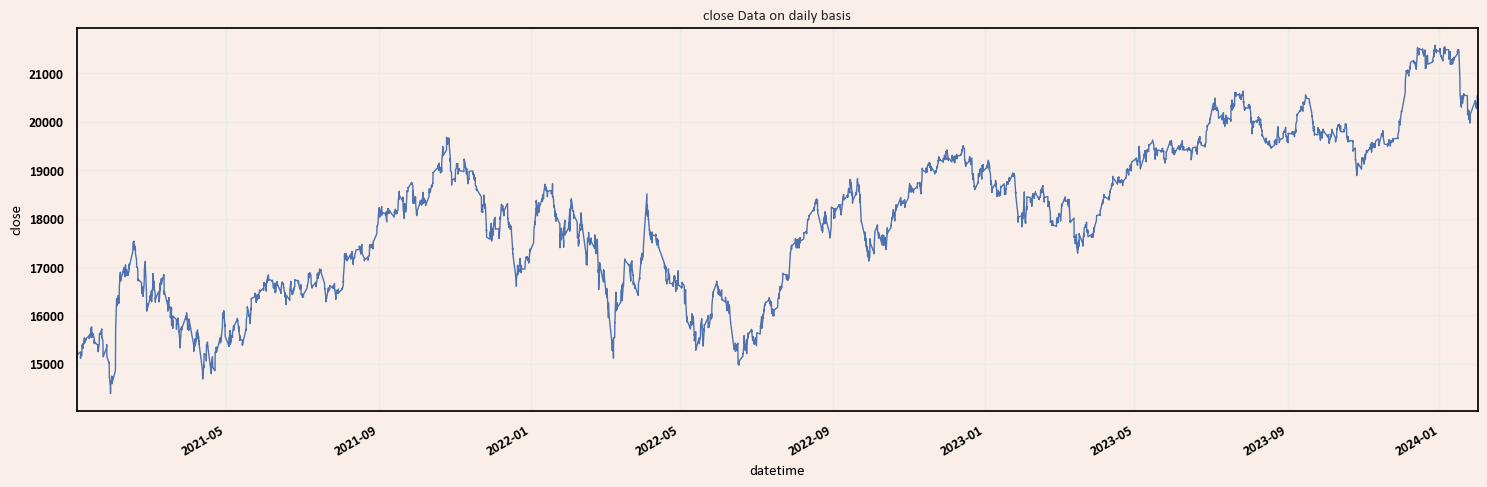

In [18]:
original_plot(df, 'close')

### Holiday Data - Step not performed as holiday data is very less

## DataFrame Preperation

In [19]:
print(pd.to_datetime(df['datetime']).dt.date.min())
print(pd.to_datetime(df['datetime']).dt.date.max())
print(pd.to_datetime(df['datetime']).dt.date.max() + timedelta(days=1)) # today + 1 day(forecast date)

2021-01-01
2024-01-31
2024-02-01


In [20]:
"""
# NO NEED to do as below due to the following:
 - We have many muhuraat days
 - We have holidays
 
"""


# # Prepare FInal Daraframe to avoid any missing time block

# #start_date = '2020-07-01'
# #end_date = '2023-02-17' # today + 1 day(forecast date)

# start_date = pd.to_datetime(df['datetime']).dt.date.min() # Data is available from 
# end_date = pd.to_datetime(df['datetime']).dt.date.max() + timedelta(days=1) # Data available till



# z = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='1H',closed='left'), columns=['datetime']) #inclusive in the newer version
# df = pd.merge(z, df, on='datetime', how='left').copy()

# df['date'] = df['datetime'].dt.date
# # Make column for Time Block here 
# df['tb'] = df['datetime'].apply(lambda x : ((x.hour*60 + x.minute)//60+1))

# print(df.shape)
# print(df.tail())
# print(f"\n Close data is missing for {df.close.isna().sum()} records")

'\n# NO NEED to do as below due to the following:\n - We have many muhuraat days\n - We have holidays\n \n'

In [21]:
# %age missing values
df.isnull().sum()/df.shape[0]*100

datetime    0.0
close       0.0
date        0.0
dtype: float64

In [22]:
df.columns

Index(['datetime', 'close', 'date'], dtype='object')

In [23]:
'''
Missing Values treatment
'''

## Interpolation Technique
df['close'] = df['close'].interpolate()

df.isnull().sum()

datetime    0
close       0
date        0
dtype: int64

In [24]:
# %age missing values
df.isnull().sum()/df.shape[0]*100

datetime    0.0
close       0.0
date        0.0
dtype: float64

## EDA

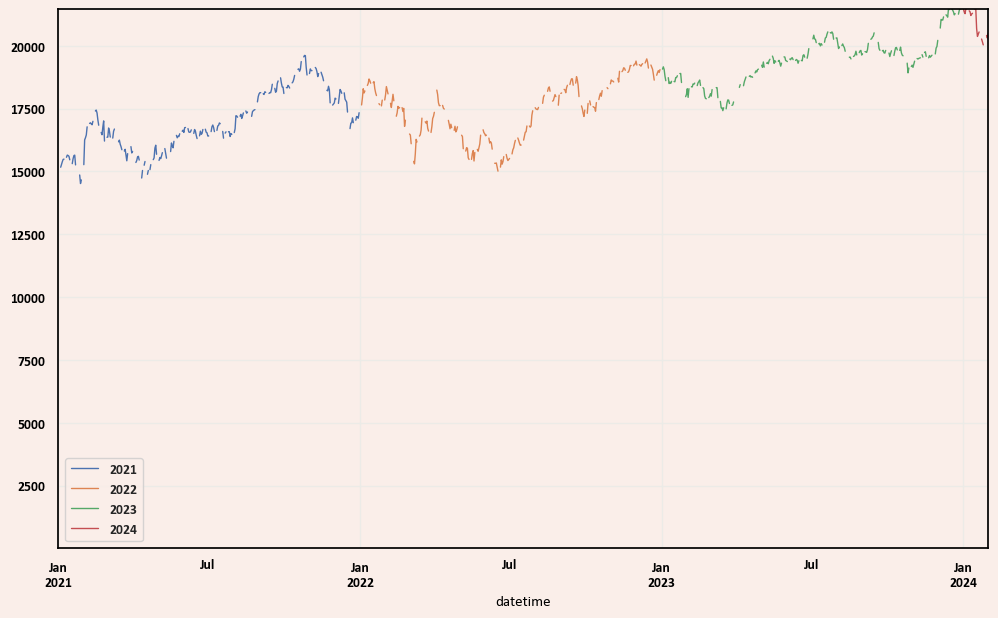

In [25]:
for x in [x for x in range(min_year, max_year+1)]:
    df[df.datetime.dt.year==x].set_index('datetime').resample('D')['close'].mean().plot(label=x, figsize=(12,7))
    plt.ylim([10, df.close.quantile(0.99)])
    plt.legend(loc="lower left")

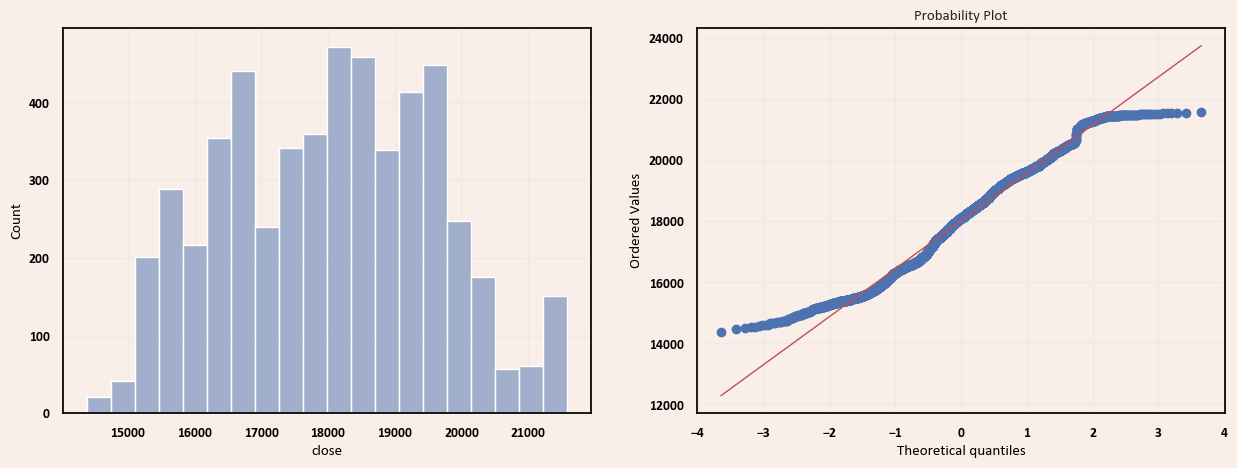

In [26]:
# To check if mcp_dam is normally distributed or not
import scipy.stats as stat
import pylab

#plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df,x='close', alpha=0.5, bins=20)

plt.subplot(1,2,2)
stat.probplot(df['close'],dist='norm',plot=pylab)
plt.show()

As curve is not following staright line, so close is not normally distributed.

In [27]:
## Checking zero or -ve mcp_dam values
df.loc[df['close']<=0, :]

,datetime,close,date


So we have few zero values, we need to replace all with NaN and later will interpolate to get values

In [28]:
df.loc[df['close']==0, 'close'] = np.nan
## Interpolation Technique
df['close'] = df['close'].interpolate()
df.isnull().sum()

datetime    0
close       0
date        0
dtype: int64

## Feature Engineering

In [29]:
def gen_datetime_features(data):
    
    try:
        #Adding time based features
        print('Adding time based features...')
        data['date'] = data.datetime.dt.date   
        data['hour'] = data.datetime.dt.hour + 1      # Categorical 24
        data['dom' ] = data.datetime.dt.day       # Categorical 30/31    
        data['month'] = data.datetime.dt.month        # Categorical 12
        data['year']=data.datetime.dt.year            # Categorical 12
        data['dow'] = data.datetime.dt.dayofweek      # Categorical 7
        data['doy'] = data.datetime.dt.dayofyear      # Categorical 365/366
        data['woy'] = data.datetime.dt.week # Categorical 52
    
        data['week_number'] = data['datetime'].apply(lambda time: time.strftime("%V"))
        # Above is Object DataType, so change to int
        data['week_number'] = data['week_number'].astype('int')
    
        # Friday
        data.loc[data.dow == 4, 'friday'] = 1
        data.loc[data.dow != 4, 'friday'] = 0   
    
    
        # Covid
        data.loc[data.year.isin([2020,2021,2022]),'covid'] = 1
        data['covid'] = data['covid'].replace(np.nan, 0)
        # Covid 1st wave
        data.loc[(data.year==2020)&(data.month.isin([3,4,5,6,7,8,9])),'covid_first_wave'] = 1
        data['covid_first_wave'] = data['covid_first_wave'].replace(np.nan, 0)
        # Covid 2nd wave
        data.loc[(data.year==2021)&(data.month.isin([3,4,5,6])),'covid_second_wave'] = 1
        data['covid_second_wave'] = data['covid_second_wave'].replace(np.nan, 0)

        print(data.columns)
        return data
    except Exception as e:
        print("Error in adding time based features")



# Creating Cyclic Time Indicators

def cyclic(data,feature):
    import math
    data['norm'] = 2 * math.pi * data[f"{feature}"] / data[f"{feature}"].max()
    data[f"cos_{feature}"] = np.cos(data["norm"])
    data[f"sin_{feature}"] = np.sin(data["norm"])
    data.drop('norm',1,inplace=True)
    return data


def gen_cyclic_features(data):
    
    try:
        print('Adding Cyclic Time Indicators........')
        data = cyclic(data,'hour')
        data = cyclic(data,'dow')
        data = cyclic(data,'doy')
        return data
    except Exception as e:
        print("Error in adding Cyclic Time Indicators")





def gen_lag_features(data):
    try:
        # Encoding TS variables
        print('Adding TB Lag features...')
        variable_used = 'close'


        # As we have large data, so better we should drop NaN values
        data['lag1h'] = data[variable_used].shift(1*4)
        data['lag2h'] = data[variable_used].shift(2*4)
        data['lag4h'] = data[variable_used].shift(4*4)
        data['lag6h'] = data[variable_used].shift(6*4)
        data['lag12h'] = data[variable_used].shift(12*4)
        data['lag1d'] = data[variable_used].shift(24*4)
        data['lag2d'] = data[variable_used].shift(2*24*4)
        data['lag3d'] = data[variable_used].shift(3*24*4)
        data['lag4d'] = data[variable_used].shift(4*24*4)
        data['lag5d'] = data[variable_used].shift(5*24*4)
        data['lag6d'] = data[variable_used].shift(6*24*4)
        data['lag7d'] = data[variable_used].shift(7*24*4)
    


    # Exponential Moving Averages
        data['mcp_dam_ewm1h'] = data[variable_used].ewm(span = 1*4).mean()
        data['mcp_dam_ewm2h'] = data[variable_used].ewm(span = 2*4).mean()
        data['mcp_dam_ewm3h'] = data[variable_used].ewm(span = 3*4).mean()
        data['mcp_dam_ewm4h'] = data[variable_used].ewm(span = 4*4).mean()
        data['mcp_dam_ewm6h'] = data[variable_used].ewm(span = 6*4).mean()
        data['mcp_dam_ewm8h'] = data[variable_used].ewm(span = 8*4).mean()
        data['mcp_dam_ewm12h'] = data[variable_used].ewm(span = 12*4).mean()
        data['mcp_dam_ewm24h'] = data[variable_used].ewm(span = 24*4).mean()
    
    
    
    
    # Moving Averages
        #for x in [4,8,12,24,48,96]:
        for x in range(1,30):
            data[f'close_rolling_mean_{x}'] = data[variable_used].rolling(x,1).mean().shift()
            data[f'close_rolling_max_{x}'] = data[variable_used].rolling(x,1).max().shift()
            data[f'close_rolling_min_{x}'] = data[variable_used].rolling(x,1).min().shift()

    # Differences
    # As per analysis these features has least importance , so we will not use 
        data['ramp1'] = data[variable_used] - data[variable_used].shift(1)
        data['ramp2'] = data[variable_used].shift(1) - data[variable_used].shift(2)
        data['ramp3'] = data[variable_used].shift(2) - data[variable_used].shift(3)
        data['ramp4'] = data[variable_used].shift(3) - data[variable_used].shift(4)
    

#     # Taking Last 7 day same TB Mean, These features are super important
#     data['avg_mcp_dam_7d'] = (data['mcp_dam'] + data['mcp_dam'].shift(96) + data['mcp_dam'].shift(2*96) + data['mcp_dam'].shift(3*96)) + data['mcp_dam'].shift(4*96) + data['mcp_dam'].shift(5*96) + data['mcp_dam'].shift(6*96) / 7
#     data['avg_mcp_dam_9d'] = (data['avg_mcp_dam_7d']*7 + data['mcp_dam'].shift(7*96) + data['mcp_dam'].shift(8*96))/9
#     data['avg_mcp_dam_11d'] = (data['avg_mcp_dam_9d']*9 + data['mcp_dam'].shift(9*96) + data['mcp_dam'].shift(10*96))/11
#     data['avg_mcp_dam_13d'] = (data['avg_mcp_dam_11d']*11 + data['mcp_dam'].shift(11*96) + data['mcp_dam'].shift(12*96))/13
#     data['avg_mcp_dam_15d'] = (data['avg_mcp_dam_13d']*13 + data['mcp_dam'].shift(13*96) + data['mcp_dam'].shift(14*96))/15
#     data['avg_mcp_dam_17d'] = (data['avg_mcp_dam_15d']*15 + data['mcp_dam'].shift(15*96) + data['mcp_dam'].shift(16*96))/17
#     data['avg_mcp_dam_19d'] = (data['avg_mcp_dam_17d']*17 + data['mcp_dam'].shift(17*96) + data['mcp_dam'].shift(18*96))/19
#     data['avg_mcp_dam_21d'] = (data['avg_mcp_dam_19d']*19 + data['mcp_dam'].shift(19*96) + data['mcp_dam'].shift(20*96))/21
    
    
    
    
        print(data.columns)
        return data
    except Exception as e:
        print(f"Error in adding Lag based features--{e}")


In [30]:
df = gen_datetime_features(df).copy()

Adding time based features...
Index(['datetime', 'close', 'date', 'hour', 'dom', 'month', 'year', 'dow',
       'doy', 'woy', 'week_number', 'friday', 'covid', 'covid_first_wave',
       'covid_second_wave'],
      dtype='object')


## Outliers checking - Not Done

## Check the Trend, Seasonality & Residual

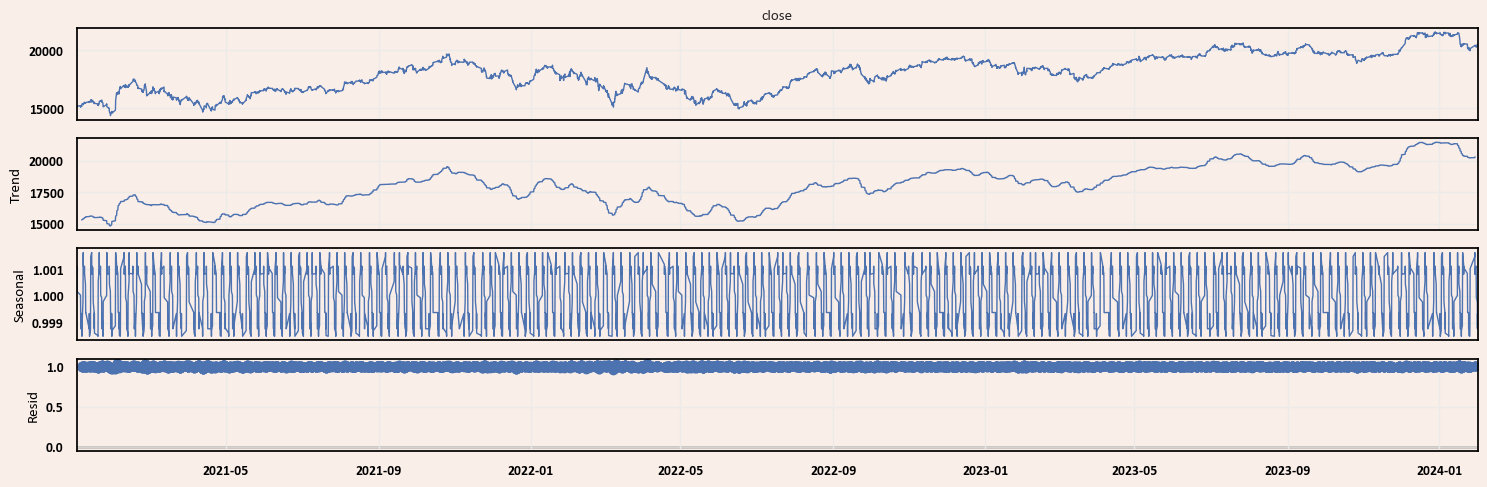

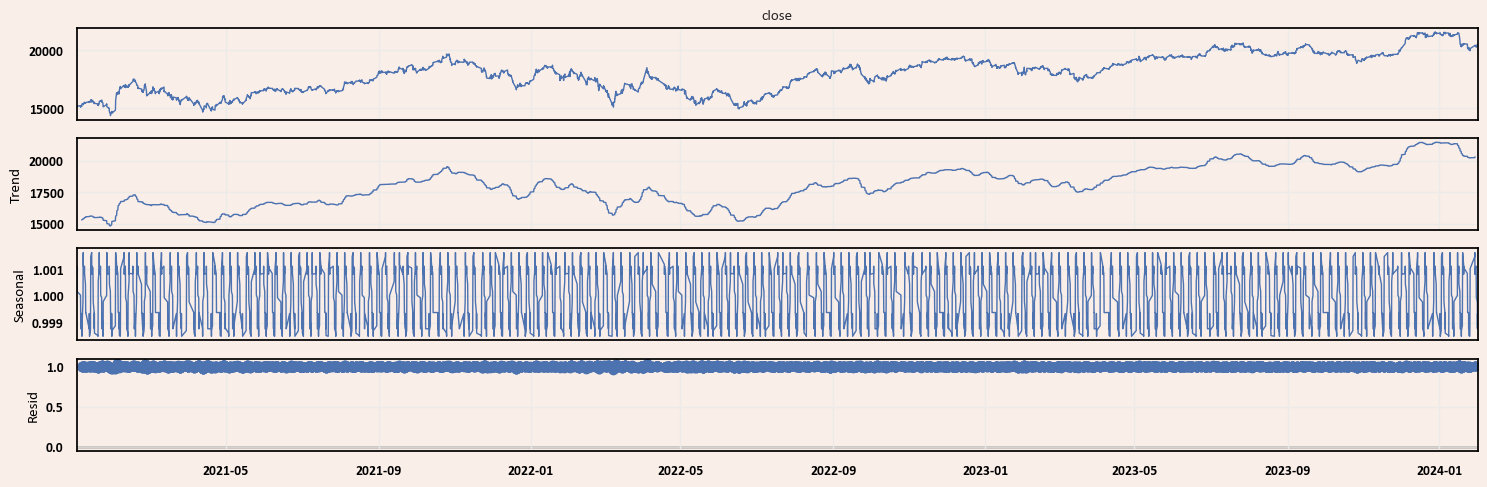

In [31]:
# Let's try decomposing the load data
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib as mpl
from pylab import rcParams
# Extra settings
seed = 42
np.random.seed(seed)
#plt.style.use('bmh')


#plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
#series = df[(df['datetime']>='2020-01-01') & (df['datetime']<'2022-01-01')].set_index(['datetime'])['close'].dropna()
series = df.set_index(['datetime'])['close'].dropna()

result = seasonal_decompose(series, model='multiplicative',period=30)
result.plot()

Seasonality is present

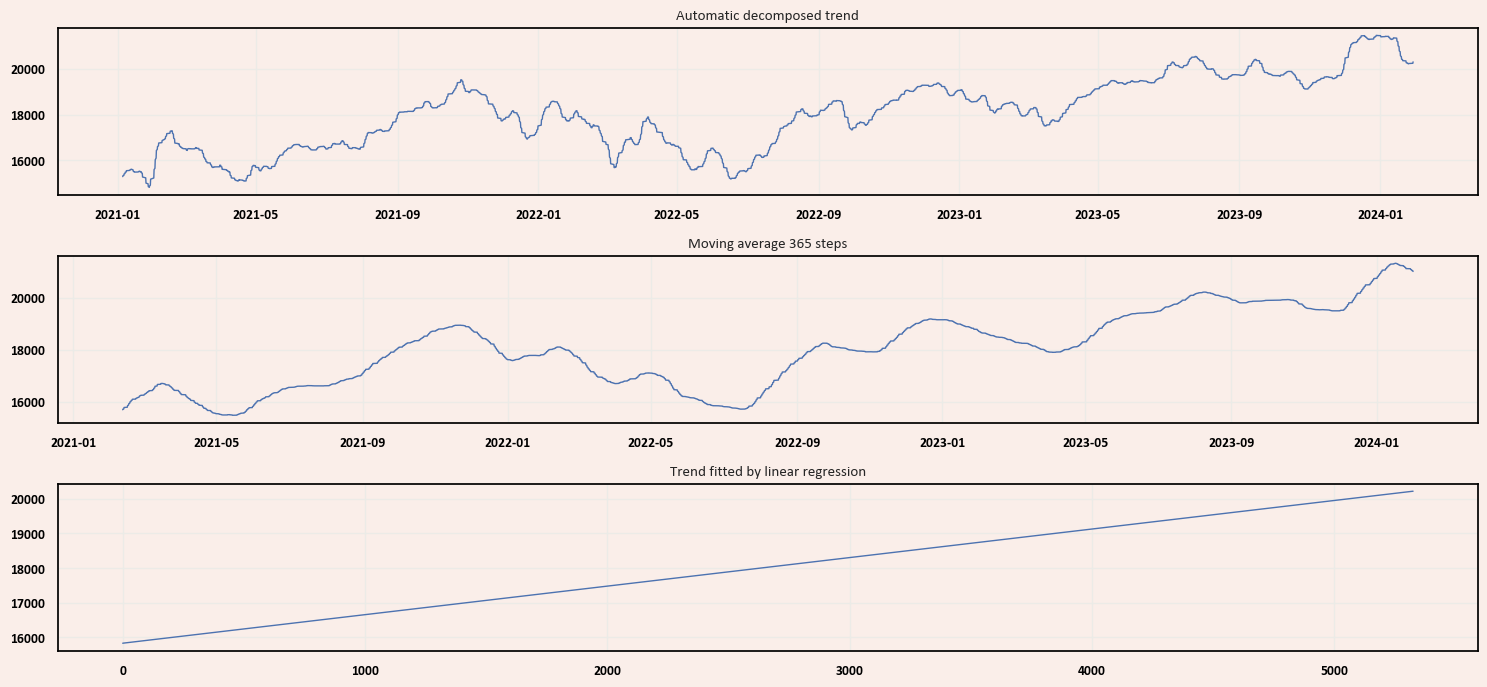

In [32]:
from sklearn.linear_model import LinearRegression
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = series.rolling(200).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 365 steps")

X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")
plt.tight_layout()

1. Seasonality is present
2. Data is non-stationary

## Check for non-stationarity

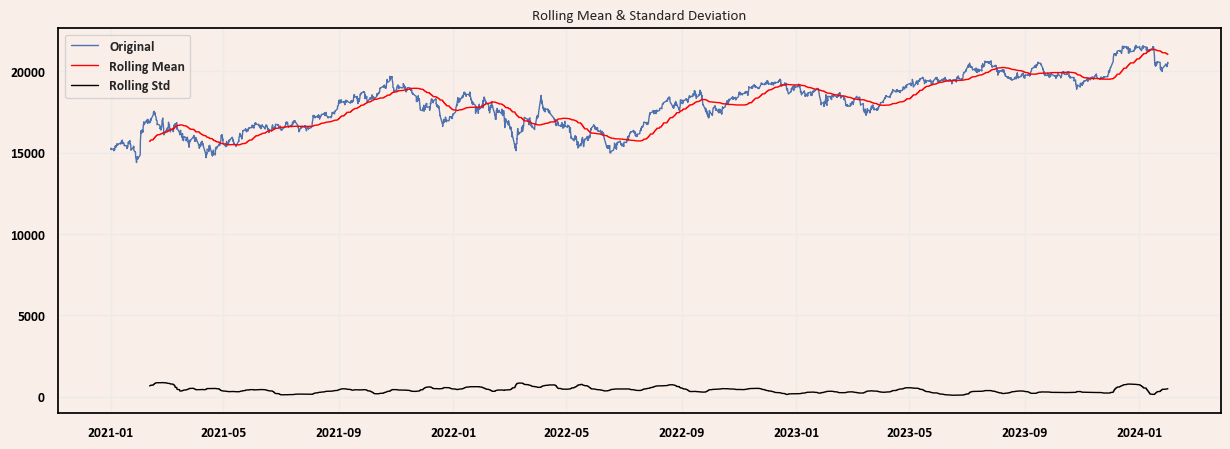

In [33]:
# Determing rolling statistics
rolmean = series.rolling(window=200).mean()
rolstd = series.rolling(window=200).std()

# Plot rolling statistics:
orig = plt.plot(series, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Mean and Standar deviation does not have a constant behaviour over the years, This proves us again a non-stationary series

## Check ACF & PACF plots for autocorelation



In [34]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# #series = df[(df['datetime']>='2020-01-01') & (df['datetime']<'2023-01-01')]['close'].dropna()
# series = df['close'].dropna()
# plot_acf(series, lags=12)
# plot_pacf(series, lags=12)
# #plot_pacf(series, lags=7)
# plt.show()

We can see from the ACF curve that there is autocorrelation.
As per PACF graph, lag - 1,2,3,4,5 are statistically significant, 
so we will include all in feature engineering.

In [35]:
## Save a copy of DataFrame for using later for different lagged Model for Multioutput
df_multi = df.copy()

## Creating Features

In [36]:
data = df.copy()
data.head(2)

,datetime,close,date,hour,dom,month,year,dow,doy,woy,week_number,friday,covid,covid_first_wave,covid_second_wave
0,2021-01-01 09:15:00,15265.05,2021-01-01,10,1,1,2021,4,1,53,53,1.0,1.0,0.0,0.0
1,2021-01-01 10:15:00,15228.65,2021-01-01,11,1,1,2021,4,1,53,53,1.0,1.0,0.0,0.0


In [37]:
#data = radial_features(data).copy() # Have to install sklego
data = gen_cyclic_features(data).copy()
data = gen_lag_features(data).copy()

Adding Cyclic Time Indicators........
Adding TB Lag features...
Index(['datetime', 'close', 'date', 'hour', 'dom', 'month', 'year', 'dow',
       'doy', 'woy',
       ...
       'close_rolling_mean_28', 'close_rolling_max_28', 'close_rolling_min_28',
       'close_rolling_mean_29', 'close_rolling_max_29', 'close_rolling_min_29',
       'ramp1', 'ramp2', 'ramp3', 'ramp4'],
      dtype='object', length=132)


In [38]:
# # Plotting how the Time Features look after getting a sin cos transformation

# sns.scatterplot(x=data.sin_hour, y=data.cos_hour)
# plt.show()

## Shifting by Lag Time forecasting



In [39]:
#target_ahead_timeblocks = 7  # Forecasting Lead Time for 15 mins candle

# Automatic calculation of target_ahead_timeblocks

def target_ahead_TB(data):
    minutes_TB = (data['datetime'][1]-data['datetime'][0]).seconds/60 # minus gives Minutes difference between 2 data rows
    target_ahead_timeblocks = (6*60)/minutes_TB + 1
    target_ahead_timeblocks = int(target_ahead_timeblocks)
    minutes_TB = int(minutes_TB)
    return (target_ahead_timeblocks, minutes_TB)  

target_ahead_timeblocks = target_ahead_TB(data)[0]
frequency_in_mins = str(target_ahead_TB(data)[1]) + "min" # We need that for generating DF for final forcast for next working day


print(target_ahead_timeblocks)
print(frequency_in_mins)

7
60min


In [40]:
# Shifting of Data as per Forecasting Lead Time
def shift_variable_by_TB(data, target_ahead_timeblocks):
    
    data['ramp_close'] = data['close'] - data['close'].shift(target_ahead_timeblocks) # Creating one feature based on the forecast horizon
    features = data.columns.tolist()
    
    
  # Creating target variable
    data['target'] = data['close'].shift(-target_ahead_timeblocks)
    
    return data

In [41]:
data = shift_variable_by_TB(data, target_ahead_timeblocks)

In [42]:
# Save DataFrame to new variable to make a check point
data_for_training = data.set_index('datetime').copy()
data_for_training.tail(28)

,close,date,hour,dom,month,year,dow,doy,woy,week_number,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-25 09:15:00,20073.65,2024-01-25,10,25,1,2024,3,25,4,4,...,20048.55,20360.677586,20581.30,20048.55,-134.50,-4.85,129.10,-9.30,-157.60,20407.40
2024-01-25 10:15:00,20000.65,2024-01-25,11,25,1,2024,3,25,4,4,...,20048.55,20351.225862,20581.30,20048.55,-73.00,-134.50,-4.85,129.10,-242.85,20411.55
2024-01-25 11:15:00,19975.05,2024-01-25,12,25,1,2024,3,25,4,4,...,20000.65,20332.405172,20581.30,20000.65,-25.60,-73.00,-134.50,-4.85,-73.50,20399.85
2024-01-25 12:15:00,19985.05,2024-01-25,13,25,1,2024,3,25,4,4,...,19975.05,20315.068966,20581.30,19975.05,10.00,-25.60,-73.00,-134.50,-108.15,20407.45
2024-01-25 13:15:00,19982.45,2024-01-25,14,25,1,2024,3,25,4,4,...,19975.05,20298.234483,20581.30,19975.05,-2.60,10.00,-25.60,-73.00,-101.45,20397.85
2024-01-25 14:15:00,20100.95,2024-01-25,15,25,1,2024,3,25,4,4,...,19975.05,20280.481034,20581.30,19975.05,118.50,-2.60,10.00,-25.60,-112.05,20430.30
2024-01-25 15:15:00,20145.60,2024-01-25,16,25,1,2024,3,25,4,4,...,19975.05,20270.772414,20581.30,19975.05,44.65,118.50,-2.60,10.00,-62.55,20436.55
2024-01-29 09:15:00,20407.40,2024-01-29,10,29,1,2024,0,29,5,5,...,19975.05,20261.301724,20581.30,19975.05,261.80,44.65,118.50,-2.60,333.75,20323.70
2024-01-29 10:15:00,20411.55,2024-01-29,11,29,1,2024,0,29,5,5,...,19975.05,20260.163793,20581.30,19975.05,4.15,261.80,44.65,118.50,410.90,20311.40


In [43]:
data.columns

Index(['datetime', 'close', 'date', 'hour', 'dom', 'month', 'year', 'dow',
       'doy', 'woy',
       ...
       'close_rolling_min_28', 'close_rolling_mean_29', 'close_rolling_max_29',
       'close_rolling_min_29', 'ramp1', 'ramp2', 'ramp3', 'ramp4',
       'ramp_close', 'target'],
      dtype='object', length=134)

In [44]:
data.isna().sum()

datetime      0
close         0
date          0
hour          0
dom           0
             ..
ramp2         2
ramp3         3
ramp4         4
ramp_close    7
target        7
Length: 134, dtype: int64

In [45]:
data.tail(10)
#data.head()

,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
5316,2024-01-30 13:15:00,20318.45,2024-01-30,14,30,1,2024,1,30,5,...,19975.05,20215.241379,20436.55,19975.05,0.15,-6.95,13.85,-12.30,-79.40,20512.75
5317,2024-01-30 14:15:00,20296.25,2024-01-30,15,30,1,2024,1,30,5,...,19975.05,20218.784483,20436.55,19975.05,-22.20,0.15,-6.95,13.85,-134.05,20496.05
5318,2024-01-30 15:15:00,20273.85,2024-01-30,16,30,1,2024,1,30,5,...,19975.05,20222.667241,20436.55,19975.05,-22.40,-22.20,0.15,-6.95,-162.70,20489.10
5319,2024-01-31 09:15:00,20455.70,2024-01-31,10,31,1,2024,2,31,5,...,19975.05,20227.089655,20436.55,19975.05,181.85,-22.40,-22.20,0.15,132.00,NaN
5320,2024-01-31 10:15:00,20531.60,2024-01-31,11,31,1,2024,2,31,5,...,19975.05,20237.889655,20455.70,19975.05,75.90,181.85,-22.40,-22.20,220.20,NaN
5321,2024-01-31 11:15:00,20536.95,2024-01-31,12,31,1,2024,2,31,5,...,19975.05,20248.246552,20531.60,19975.05,5.35,75.90,181.85,-22.40,211.70,NaN
5322,2024-01-31 12:15:00,20516.60,2024-01-31,13,31,1,2024,2,31,5,...,19975.05,20258.365517,20536.95,19975.05,-20.35,5.35,75.90,181.85,198.30,NaN
5323,2024-01-31 13:15:00,20512.75,2024-01-31,14,31,1,2024,2,31,5,...,19975.05,20274.505172,20536.95,19975.05,-3.85,-20.35,5.35,75.90,194.30,NaN
5324,2024-01-31 14:15:00,20496.05,2024-01-31,15,31,1,2024,2,31,5,...,19975.05,20288.972414,20536.95,19975.05,-16.70,-3.85,-20.35,5.35,199.80,NaN
5325,2024-01-31 15:15:00,20489.10,2024-01-31,16,31,1,2024,2,31,5,...,19975.05,20303.184483,20536.95,19975.05,-6.95,-16.70,-3.85,-20.35,215.25,NaN


## Check all NaN

In [46]:
data[data.isna().any(axis=1)].head(10)

,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
0,2021-01-01 09:15:00,15265.05,2021-01-01,10,1,1,2021,4,1,53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15243.40
1,2021-01-01 10:15:00,15228.65,2021-01-01,11,1,1,2021,4,1,53,...,15265.05,15265.050000,15265.05,15265.05,-36.40,NaN,NaN,NaN,NaN,15109.20
2,2021-01-01 11:15:00,15214.00,2021-01-01,12,1,1,2021,4,1,53,...,15228.65,15246.850000,15265.05,15228.65,-14.65,-36.40,NaN,NaN,NaN,15147.80
3,2021-01-01 12:15:00,15220.35,2021-01-01,13,1,1,2021,4,1,53,...,15214.00,15235.900000,15265.05,15214.00,6.35,-14.65,-36.40,NaN,NaN,15159.35
4,2021-01-01 13:15:00,15232.25,2021-01-01,14,1,1,2021,4,1,53,...,15214.00,15232.012500,15265.05,15214.00,11.90,6.35,-14.65,-36.40,NaN,15149.30
5,2021-01-01 14:15:00,15182.20,2021-01-01,15,1,1,2021,4,1,53,...,15214.00,15232.060000,15265.05,15214.00,-50.05,11.90,6.35,-14.65,NaN,15184.85
6,2021-01-01 15:15:00,15184.50,2021-01-01,16,1,1,2021,4,1,53,...,15182.20,15223.750000,15265.05,15182.20,2.30,-50.05,11.90,6.35,NaN,15193.05
7,2021-01-04 09:15:00,15243.40,2021-01-04,10,4,1,2021,0,4,1,...,15182.20,15218.142857,15265.05,15182.20,58.90,2.30,-50.05,11.90,-21.65,15167.90
8,2021-01-04 10:15:00,15109.20,2021-01-04,11,4,1,2021,0,4,1,...,15182.20,15221.300000,15265.05,15182.20,-134.20,58.90,2.30,-50.05,-119.45,15248.85
9,2021-01-04 11:15:00,15147.80,2021-01-04,12,4,1,2021,0,4,1,...,15109.20,15208.844444,15265.05,15109.20,38.60,-134.20,58.90,2.30,-66.20,15249.35


In [47]:
data[data.isna().any(axis=1)].tail(10)

,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
669,2021-05-26 10:15:00,16431.55,2021-05-26,11,26,5,2021,2,146,21,...,15828.90,16233.287931,16453.40,15828.90,119.10,-15.45,11.90,47.15,90.95,16352.30
670,2021-05-26 11:15:00,16424.30,2021-05-26,12,26,5,2021,2,146,21,...,15828.90,16247.751724,16453.40,15828.90,-7.25,119.10,-15.45,11.90,58.65,16399.05
671,2021-05-26 12:15:00,16425.05,2021-05-26,13,26,5,2021,2,146,21,...,15828.90,16262.762069,16453.40,15828.90,0.75,-7.25,119.10,-15.45,53.70,16410.65
5319,2024-01-31 09:15:00,20455.70,2024-01-31,10,31,1,2024,2,31,5,...,19975.05,20227.089655,20436.55,19975.05,181.85,-22.40,-22.20,0.15,132.00,NaN
5320,2024-01-31 10:15:00,20531.60,2024-01-31,11,31,1,2024,2,31,5,...,19975.05,20237.889655,20455.70,19975.05,75.90,181.85,-22.40,-22.20,220.20,NaN
5321,2024-01-31 11:15:00,20536.95,2024-01-31,12,31,1,2024,2,31,5,...,19975.05,20248.246552,20531.60,19975.05,5.35,75.90,181.85,-22.40,211.70,NaN
5322,2024-01-31 12:15:00,20516.60,2024-01-31,13,31,1,2024,2,31,5,...,19975.05,20258.365517,20536.95,19975.05,-20.35,5.35,75.90,181.85,198.30,NaN
5323,2024-01-31 13:15:00,20512.75,2024-01-31,14,31,1,2024,2,31,5,...,19975.05,20274.505172,20536.95,19975.05,-3.85,-20.35,5.35,75.90,194.30,NaN
5324,2024-01-31 14:15:00,20496.05,2024-01-31,15,31,1,2024,2,31,5,...,19975.05,20288.972414,20536.95,19975.05,-16.70,-3.85,-20.35,5.35,199.80,NaN
5325,2024-01-31 15:15:00,20489.10,2024-01-31,16,31,1,2024,2,31,5,...,19975.05,20303.184483,20536.95,19975.05,-6.95,-16.70,-3.85,-20.35,215.25,NaN


#### So above shows that we have top 671 rows as NaN due to moving averages and all
#### Also bottom 7 rows are with NaN as Target which is obvious as we have shifted by 7 (due to 15 min candle) to make time series as regression problem

In [48]:
# Function to make feature extraction systematic

def diff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    return list(c - d)

In [49]:
# Feature segregation

def get_final_features(data):
    extra_features = ['weekend', 'date', 'year', 'target'] # Dont include 'datetime'
    X_features = [x for x in data.columns if x not in extra_features+['target']]
    return X_features

y_features = ['datetime', 'target']

X_features = get_final_features(data)
#print(X_features)
print(data[X_features].shape)

(5326, 131)


## ********* Filtered and Store the last rows for getting prediction for NEXT day*******

In [50]:
next_day_df_prediction = data.iloc[-target_ahead_timeblocks:, :-1].copy()
next_day_df_prediction

,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_max_28,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close
5319,2024-01-31 09:15:00,20455.70,2024-01-31,10,31,1,2024,2,31,5,...,20436.55,19975.05,20227.089655,20436.55,19975.05,181.85,-22.40,-22.20,0.15,132.00
5320,2024-01-31 10:15:00,20531.60,2024-01-31,11,31,1,2024,2,31,5,...,20455.70,19975.05,20237.889655,20455.70,19975.05,75.90,181.85,-22.40,-22.20,220.20
5321,2024-01-31 11:15:00,20536.95,2024-01-31,12,31,1,2024,2,31,5,...,20531.60,19975.05,20248.246552,20531.60,19975.05,5.35,75.90,181.85,-22.40,211.70
5322,2024-01-31 12:15:00,20516.60,2024-01-31,13,31,1,2024,2,31,5,...,20536.95,19975.05,20258.365517,20536.95,19975.05,-20.35,5.35,75.90,181.85,198.30
5323,2024-01-31 13:15:00,20512.75,2024-01-31,14,31,1,2024,2,31,5,...,20536.95,19975.05,20274.505172,20536.95,19975.05,-3.85,-20.35,5.35,75.90,194.30
5324,2024-01-31 14:15:00,20496.05,2024-01-31,15,31,1,2024,2,31,5,...,20536.95,19975.05,20288.972414,20536.95,19975.05,-16.70,-3.85,-20.35,5.35,199.80
5325,2024-01-31 15:15:00,20489.10,2024-01-31,16,31,1,2024,2,31,5,...,20536.95,19975.05,20303.184483,20536.95,19975.05,-6.95,-16.70,-3.85,-20.35,215.25


## Dropping Missing Values

In [51]:
print(f'Before Dropping nans: {data_for_training.shape}')
data_for_training.dropna(inplace=True) # Dropping nans  # HERE PROBLEM IS THAT WE LOST NEXT DAY PREDICTION DATA
data_for_training.reset_index(inplace=True) # Resetting index
print(data_for_training.shape)
data_for_training.tail(10)

Before Dropping nans: (5326, 133)
(4647, 134)


,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
4637,2024-01-29 13:15:00,20397.85,2024-01-29,14,29,1,2024,0,29,5,...,19975.05,20247.301724,20581.30,19975.05,-9.60,7.60,-11.70,4.15,415.40,20318.45
4638,2024-01-29 14:15:00,20430.30,2024-01-29,15,29,1,2024,0,29,5,...,19975.05,20240.975862,20579.30,19975.05,32.45,-9.60,7.60,-11.70,329.35,20296.25
4639,2024-01-29 15:15:00,20436.55,2024-01-29,16,29,1,2024,0,29,5,...,19975.05,20235.837931,20557.25,19975.05,6.25,32.45,-9.60,7.60,290.95,20273.85
4640,2024-01-30 09:15:00,20323.70,2024-01-30,10,30,1,2024,1,30,5,...,19975.05,20231.887931,20557.25,19975.05,-112.85,6.25,32.45,-9.60,-83.70,20455.70
4641,2024-01-30 10:15:00,20311.40,2024-01-30,11,30,1,2024,1,30,5,...,19975.05,20223.834483,20536.20,19975.05,-12.30,-112.85,6.25,32.45,-100.15,20531.60
4642,2024-01-30 11:15:00,20325.25,2024-01-30,12,30,1,2024,1,30,5,...,19975.05,20216.082759,20450.25,19975.05,13.85,-12.30,-112.85,6.25,-74.60,20536.95
4643,2024-01-30 12:15:00,20318.30,2024-01-30,13,30,1,2024,1,30,5,...,19975.05,20211.772414,20436.55,19975.05,-6.95,13.85,-12.30,-112.85,-89.15,20516.60
4644,2024-01-30 13:15:00,20318.45,2024-01-30,14,30,1,2024,1,30,5,...,19975.05,20215.241379,20436.55,19975.05,0.15,-6.95,13.85,-12.30,-79.40,20512.75
4645,2024-01-30 14:15:00,20296.25,2024-01-30,15,30,1,2024,1,30,5,...,19975.05,20218.784483,20436.55,19975.05,-22.20,0.15,-6.95,13.85,-134.05,20496.05
4646,2024-01-30 15:15:00,20273.85,2024-01-30,16,30,1,2024,1,30,5,...,19975.05,20222.667241,20436.55,19975.05,-22.40,-22.20,0.15,-6.95,-162.70,20489.10


## Train Test Split

In [52]:
## Experiments to check code

print(data_for_training['datetime'].max())

print(data_for_training['datetime'].max() - np.timedelta64(1, 'M'))

st_date = data_for_training['datetime'].max() - np.timedelta64(1, 'M')
f = dt.datetime(st_date.year, st_date.month, st_date.day, 9, 15)
print(f)

2024-01-30 15:15:00
2023-12-31 04:45:54
2023-12-31 09:15:00


In [53]:
#months_for_cutoff = 3
#months_for_cutoff = 2

val_cut = data_for_training['datetime'].max() - np.timedelta64(3, 'M')
test_cut = data_for_training['datetime'].max() - np.timedelta64(1, 'M')

validation_cutoff = dt.datetime(val_cut.year, val_cut.month, val_cut.day, 15, 15)
test_cutoff = dt.datetime(test_cut.year, test_cut.month, test_cut.day, 15, 15)

print(f"X Train Date till: {validation_cutoff}")
print(f"X Validation Date till: {test_cutoff}")
#print(f"X Test Date till: {data_for_training['datetime'].max()}")

X Train Date till: 2023-10-31 15:15:00
X Validation Date till: 2023-12-31 15:15:00


In [54]:
X = data_for_training[X_features].copy()
y = data_for_training[y_features].copy()
X.columns

Index(['datetime', 'close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy',
       'week_number', 'friday',
       ...
       'close_rolling_max_28', 'close_rolling_min_28', 'close_rolling_mean_29',
       'close_rolling_max_29', 'close_rolling_min_29', 'ramp1', 'ramp2',
       'ramp3', 'ramp4', 'ramp_close'],
      dtype='object', length=131)

In [55]:
def train_valid_test_split(X, y, validation_cutoff, test_cutoff):
    X_train = X[X['datetime'] <= validation_cutoff].iloc[:,1:].copy()
    y_train = y[y['datetime'] <= validation_cutoff].iloc[:,1:].copy()
    X_valid = X[(X['datetime'] > validation_cutoff) & (X['datetime'] <= test_cutoff)].iloc[:,1:].copy()
    y_valid = y[(y['datetime'] > validation_cutoff) & (y['datetime'] <= test_cutoff)].iloc[:,1:].copy()
    X_test = X[X['datetime'] > test_cutoff].iloc[:,1:].copy()
    y_test = y[y['datetime'] > test_cutoff].iloc[:,1:].copy()
    print(f'X Train: {X_train.shape}')
    print(f'X Validation: {X_valid.shape}')
    print(f'X Test: {X_test.shape}')
    print(f'y Train: {y_train.shape}')
    print(f'y Validation: {y_valid.shape}')
    print(f'y Test: {y_test.shape}')
    
    print("\n")
  
    X_train_date = X[X['datetime'] <= validation_cutoff].iloc[:,0:1].copy()
    X_valid_date = X[(X['datetime'] > validation_cutoff) & (X['datetime'] <= test_cutoff)].iloc[:,0:1].copy()
    X_test_date = X[X['datetime'] > test_cutoff].iloc[:,0:1].copy()
    print(f"X Train Date: {X_train_date['datetime'].max()}")
    print(f"X Validation Date: {X_valid_date['datetime'].max()}")
    print(f"X Test Date: {X_test_date['datetime'].max()}")

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [56]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y, validation_cutoff, test_cutoff)

X Train: (4219, 130)
X Validation: (281, 130)
X Test: (147, 130)
y Train: (4219, 1)
y Validation: (281, 1)
y Test: (147, 1)


X Train Date: 2023-10-31 15:15:00
X Validation Date: 2023-12-29 15:15:00
X Test Date: 2024-01-30 15:15:00


In [57]:
X.columns

Index(['datetime', 'close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy',
       'week_number', 'friday',
       ...
       'close_rolling_max_28', 'close_rolling_min_28', 'close_rolling_mean_29',
       'close_rolling_max_29', 'close_rolling_min_29', 'ramp1', 'ramp2',
       'ramp3', 'ramp4', 'ramp_close'],
      dtype='object', length=131)

In [58]:
X_train.columns

Index(['close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy', 'week_number',
       'friday', 'covid',
       ...
       'close_rolling_max_28', 'close_rolling_min_28', 'close_rolling_mean_29',
       'close_rolling_max_29', 'close_rolling_min_29', 'ramp1', 'ramp2',
       'ramp3', 'ramp4', 'ramp_close'],
      dtype='object', length=130)

In [59]:
X_train.tail()

,close,hour,dom,month,dow,doy,woy,week_number,friday,covid,...,close_rolling_max_28,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close
4214,19220.20,12,31,10,1,304,44,44,0.0,0.0,...,19355.45,18887.15,19128.250000,19419.95,18887.15,-29.45,4.45,-9.20,15.95,31.95
4215,19252.40,13,31,10,1,304,44,44,0.0,0.0,...,19281.60,18887.15,19121.362069,19355.45,18887.15,32.20,-29.45,4.45,-9.20,28.45
4216,19247.55,14,31,10,1,304,44,44,0.0,0.0,...,19281.60,18887.15,19117.808621,19281.60,18887.15,-4.85,32.20,-29.45,4.45,56.35
4217,19201.70,15,31,10,1,304,44,44,0.0,0.0,...,19254.40,18887.15,19119.200000,19281.60,18887.15,-45.85,-4.85,32.20,-29.45,-36.75
4218,19204.00,16,31,10,1,304,44,44,0.0,0.0,...,19254.40,18887.15,19116.444828,19254.40,18887.15,2.30,-45.85,-4.85,32.20,-50.40


# Mode-1 (XGBoost)

In [60]:
### Feature Selection


# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    #tree_method = "gpu_hist", # To use GPU
    booster='gbtree',
    objective='reg:squarederror',
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.1,
    gamma=0,alpha=0,
    seed=2
)


# Here we are not using scaled features as its not required for xgbboost reg
eval_set = [(X_train, y_train), (X_valid, y_valid)]
xgb_model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set, verbose=False)
#xgb_model.fit(X_train, y_train, eval_metric="mae", eval_set=eval_set, verbose=200)


XGBRegressor(alpha=0, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

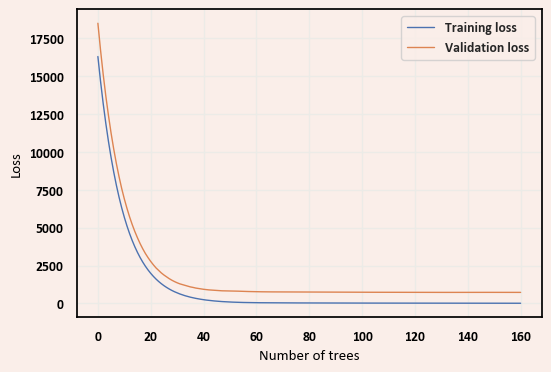

In [61]:
results = xgb_model.evals_result()

plt.figure(figsize=(6,4))
plt.plot(results["validation_0"]["mae"], label="Training loss")
plt.plot(results["validation_1"]["mae"], label="Validation loss")
#plt.axvline(xgb_model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
#print(f'No of Optimum Tress = {xgb_model.best_ntree_limit}')

In [62]:
print(f'No of Optimum Tress = {xgb_model.best_ntree_limit}')

No of Optimum Tress = 131


In [63]:
feature_names= X_train.columns.tolist()
xgb_features = pd.DataFrame({'feature_names': feature_names, 
                             'feature_importance': xgb_model.feature_importances_}).sort_values(by=['feature_importance'], ascending=False).reset_index(drop=True)
xgb_features

,feature_names,feature_importance
0,close_rolling_min_18,0.168830
1,mcp_dam_ewm1h,0.143540
2,close_rolling_min_6,0.106956
3,close_rolling_max_7,0.074778
4,close_rolling_max_17,0.067660
...,...,...
125,week_number,0.000000
126,covid_first_wave,0.000000
127,cos_hour,0.000000
128,close_rolling_min_1,0.000000


In [64]:
best_features = xgb_features[xgb_features['feature_importance']>=0.01]['feature_names'].tolist()
best_features

['close_rolling_min_18',
 'mcp_dam_ewm1h',
 'close_rolling_min_6',
 'close_rolling_max_7',
 'close_rolling_max_17',
 'close_rolling_max_19',
 'close',
 'close_rolling_min_5',
 'close_rolling_max_6',
 'close_rolling_min_23',
 'mcp_dam_ewm2h',
 'close_rolling_min_20',
 'close_rolling_max_21',
 'close_rolling_min_2',
 'close_rolling_max_10',
 'close_rolling_max_5']

In [65]:
#xgb_features.to_csv('features.csv', index=False) # Storing important features for analyzing

## Check all Best Features

<Axes: >

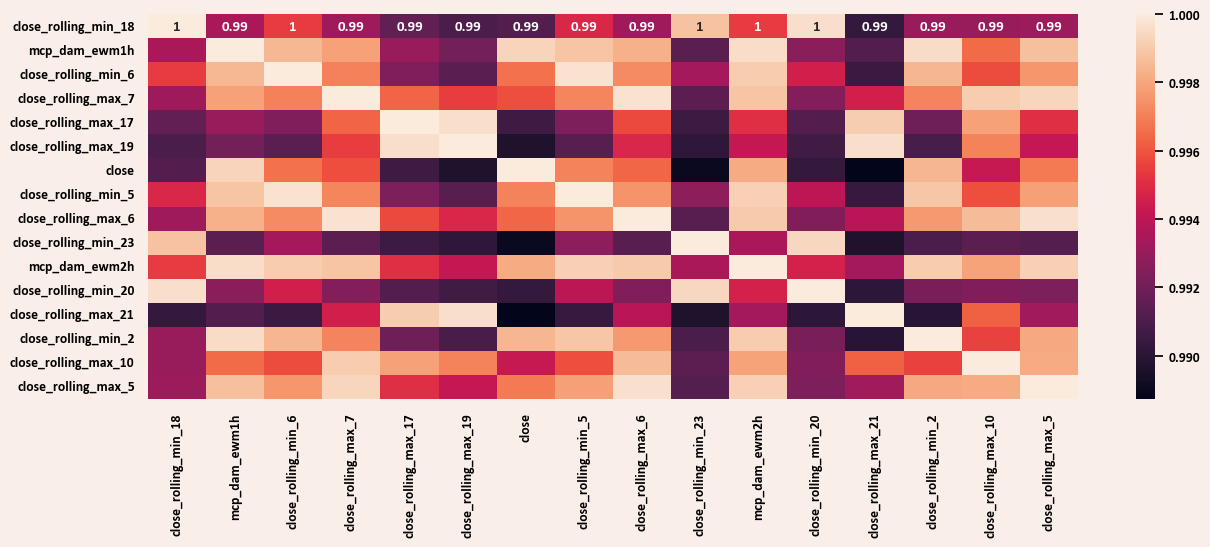

In [66]:
sns.heatmap(data[best_features].corr(), annot=True)

In [67]:
#sns.pairplot(data[best_features]) #later

## Hyperparameter Tuning with Optuna

In [68]:
#pip install optuna

In [69]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Hyper Parameters
    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_int("lambda", 0, 100, step=10),
        "alpha": trial.suggest_int("alpha", 0, 100, step=10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.8, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 0.9),
        "max_leaves": trial.suggest_int("max_leaves", 1000, 2000,step=20),
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        #"grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        #tree_method = "gpu_hist", # To use GPU
        n_estimators=2000,
        **param
        )
    model.fit(X_train[best_features],y_train,eval_set=[(X_valid[best_features],y_valid)],eval_metric='rmse',early_stopping_rounds=100,verbose=100)
    preds = model.predict(X_valid[best_features])
    error = mean_squared_error(y_valid, preds)
    return error
 
study = optuna.create_study(direction='minimize',study_name="XGB")
study.optimize(objective, n_trials=10) # We can increase n_trials to check more combinations, later increse
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-01 06:49:44,035] A new study created in memory with name: XGB


[0]	validation_0-rmse:18763.42714
[100]	validation_0-rmse:719.95629
[200]	validation_0-rmse:693.13886
[268]	validation_0-rmse:695.33641


[I 2024-02-01 06:49:45,576] Trial 0 finished with value: 478866.9274617949 and parameters: {'booster': 'gbtree', 'lambda': 100, 'alpha': 50, 'gamma': 7.182252310250245e-07, 'subsample': 0.885892231140938, 'min_child_weight': 8, 'colsample_bytree': 0.8475688987640748, 'max_leaves': 1160, 'max_depth': 15, 'learning_rate': 0.09631769400141627}. Best is trial 0 with value: 478866.9274617949.


[0]	validation_0-rmse:17748.88192
[100]	validation_0-rmse:688.60630
[181]	validation_0-rmse:694.95408


[I 2024-02-01 06:49:46,565] Trial 1 finished with value: 473215.0232581424 and parameters: {'booster': 'gbtree', 'lambda': 30, 'alpha': 50, 'gamma': 0.3610632762248035, 'subsample': 0.8708405420992376, 'min_child_weight': 8, 'colsample_bytree': 0.8696184658833191, 'max_leaves': 1680, 'max_depth': 13, 'learning_rate': 0.15108638821009104}. Best is trial 1 with value: 473215.0232581424.


[0]	validation_0-rmse:18165.42350
[100]	validation_0-rmse:718.58293
[200]	validation_0-rmse:718.17548
[228]	validation_0-rmse:718.23899


[I 2024-02-01 06:49:47,893] Trial 2 finished with value: 514182.54448247456 and parameters: {'booster': 'gbtree', 'lambda': 60, 'alpha': 40, 'gamma': 0.43045236688622307, 'subsample': 0.8070751158789754, 'min_child_weight': 6, 'colsample_bytree': 0.875704973582368, 'max_leaves': 1100, 'max_depth': 13, 'learning_rate': 0.1290663518394206}. Best is trial 1 with value: 473215.0232581424.


[0]	validation_0-rmse:18918.83558
[100]	validation_0-rmse:738.09788
[200]	validation_0-rmse:717.50900
[269]	validation_0-rmse:718.23726


[I 2024-02-01 06:49:49,398] Trial 3 finished with value: 514370.4272527088 and parameters: {'booster': 'gbtree', 'lambda': 70, 'alpha': 10, 'gamma': 3.209182949647139e-08, 'subsample': 0.8702444498613238, 'min_child_weight': 7, 'colsample_bytree': 0.8393334812126105, 'max_leaves': 1400, 'max_depth': 13, 'learning_rate': 0.08681695370427739}. Best is trial 1 with value: 473215.0232581424.


[0]	validation_0-rmse:16707.16207
[100]	validation_0-rmse:743.75710
[200]	validation_0-rmse:738.33483
[242]	validation_0-rmse:738.87125


[I 2024-02-01 06:49:50,661] Trial 4 finished with value: 544682.3210446378 and parameters: {'booster': 'gbtree', 'lambda': 80, 'alpha': 70, 'gamma': 0.0007961581414583531, 'subsample': 0.8354286203177252, 'min_child_weight': 3, 'colsample_bytree': 0.8779082154484825, 'max_leaves': 1660, 'max_depth': 10, 'learning_rate': 0.21217945375044986}. Best is trial 1 with value: 473215.0232581424.


[0]	validation_0-rmse:15955.41210
[100]	validation_0-rmse:719.62185
[162]	validation_0-rmse:723.45881


[I 2024-02-01 06:49:51,666] Trial 5 finished with value: 513280.9295222717 and parameters: {'booster': 'gbtree', 'lambda': 80, 'alpha': 30, 'gamma': 0.41917268409359354, 'subsample': 0.8580365949102224, 'min_child_weight': 6, 'colsample_bytree': 0.8304118004522291, 'max_leaves': 1500, 'max_depth': 15, 'learning_rate': 0.25456717614329016}. Best is trial 1 with value: 473215.0232581424.


[0]	validation_0-rmse:19287.41837
[100]	validation_0-rmse:806.71144
[200]	validation_0-rmse:669.80714
[300]	validation_0-rmse:664.02013
[400]	validation_0-rmse:662.83758
[454]	validation_0-rmse:663.59440


[I 2024-02-01 06:49:54,086] Trial 6 finished with value: 438592.6005019935 and parameters: {'booster': 'gbtree', 'lambda': 80, 'alpha': 80, 'gamma': 0.6620102810962496, 'subsample': 0.8793422180129367, 'min_child_weight': 10, 'colsample_bytree': 0.8982541021808287, 'max_leaves': 1620, 'max_depth': 12, 'learning_rate': 0.06622525674806583}. Best is trial 6 with value: 438592.6005019935.


[0]	validation_0-rmse:16854.60736
[100]	validation_0-rmse:737.20382
[188]	validation_0-rmse:736.29126


[I 2024-02-01 06:49:55,958] Trial 7 finished with value: 541211.1831312848 and parameters: {'booster': 'gbtree', 'lambda': 80, 'alpha': 80, 'gamma': 1.1721605829355123e-07, 'subsample': 0.8397843543240171, 'min_child_weight': 4, 'colsample_bytree': 0.8735017356689865, 'max_leaves': 1900, 'max_depth': 15, 'learning_rate': 0.20382242084512822}. Best is trial 6 with value: 438592.6005019935.


[0]	validation_0-rmse:16050.12231
[100]	validation_0-rmse:735.19501
[200]	validation_0-rmse:735.16544
[217]	validation_0-rmse:734.58029


[I 2024-02-01 06:49:57,403] Trial 8 finished with value: 539142.8390514071 and parameters: {'booster': 'gbtree', 'lambda': 30, 'alpha': 100, 'gamma': 0.06604740961416443, 'subsample': 0.8708546392335275, 'min_child_weight': 4, 'colsample_bytree': 0.8726525363046587, 'max_leaves': 1680, 'max_depth': 11, 'learning_rate': 0.24577657575081446}. Best is trial 6 with value: 438592.6005019935.


[0]	validation_0-rmse:19621.14827
[100]	validation_0-rmse:1167.57827
[200]	validation_0-rmse:703.93209
[300]	validation_0-rmse:664.41712
[400]	validation_0-rmse:659.82957
[497]	validation_0-rmse:661.57658


[I 2024-02-01 06:50:00,212] Trial 9 finished with value: 435232.60116900346 and parameters: {'booster': 'gbtree', 'lambda': 90, 'alpha': 60, 'gamma': 4.895697859643548e-05, 'subsample': 0.8464456110182471, 'min_child_weight': 10, 'colsample_bytree': 0.8795672502631793, 'max_leaves': 1420, 'max_depth': 15, 'learning_rate': 0.047544403966483094}. Best is trial 9 with value: 435232.60116900346.


Number of finished trials: 10
Best trial: {'booster': 'gbtree', 'lambda': 90, 'alpha': 60, 'gamma': 4.895697859643548e-05, 'subsample': 0.8464456110182471, 'min_child_weight': 10, 'colsample_bytree': 0.8795672502631793, 'max_leaves': 1420, 'max_depth': 15, 'learning_rate': 0.047544403966483094}


In [70]:
study.best_params

{'booster': 'gbtree',
 'lambda': 90,
 'alpha': 60,
 'gamma': 4.895697859643548e-05,
 'subsample': 0.8464456110182471,
 'min_child_weight': 10,
 'colsample_bytree': 0.8795672502631793,
 'max_leaves': 1420,
 'max_depth': 15,
 'learning_rate': 0.047544403966483094}

In [71]:
param = study.best_params
xgbreg = xgb.XGBRegressor(
    objective='reg:squarederror',
    #tree_method = "gpu_hist", # To use GPU
    n_estimators=1000,    
    **param
    )
xgbreg.fit(X_train[best_features],y_train,eval_set=[(X_valid[best_features],y_valid)],eval_metric='rmse',early_stopping_rounds=20,verbose=100)

[0]	validation_0-rmse:19621.14827
[100]	validation_0-rmse:1167.57827
[200]	validation_0-rmse:703.93209
[300]	validation_0-rmse:664.41712
[400]	validation_0-rmse:659.82957
[417]	validation_0-rmse:660.16032


XGBRegressor(alpha=60, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8795672502631793, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.895697859643548e-05, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=90,
             learning_rate=0.047544403966483094, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=1420,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None, ...)

In [72]:
# Making predictions with the tuned model
pred_train = xgbreg.predict(X_train[best_features])
pred_valid = xgbreg.predict(X_valid[best_features])
pred_test = xgbreg.predict(X_test[best_features])

In [73]:
# Evaluate model accuracy 
from sklearn.metrics import mean_squared_error
print(f"Train MSE: {mean_squared_error(y_train['target'],pred_train)}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train['target'],pred_train))}")
print(f"valid MSE: {mean_squared_error(y_valid['target'],pred_valid)}")
print(f"valid RMSE: {np.sqrt(mean_squared_error(y_valid['target'],pred_valid))}")
print(f"Test MSE: {mean_squared_error(y_test['target'],pred_test)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test['target'],pred_test))}")

Train MSE: 7782.849663824357
Train RMSE: 88.22046057363539
valid MSE: 435232.60116900346
valid RMSE: 659.7216088389127
Test MSE: 548442.9583435131
Test RMSE: 740.569347423665


In [74]:
result = y[y['datetime'] > test_cutoff].copy()
result[f'prediction_xgb_{stock}'] = pred_test
result.tail(10)

,datetime,target,prediction_xgb_FINNIFTY
4637,2024-01-29 13:15:00,20318.45,20359.152344
4638,2024-01-29 14:15:00,20296.25,20374.447266
4639,2024-01-29 15:15:00,20273.85,20392.097656
4640,2024-01-30 09:15:00,20455.70,20378.505859
4641,2024-01-30 10:15:00,20531.60,20342.687500
4642,2024-01-30 11:15:00,20536.95,20370.136719
4643,2024-01-30 12:15:00,20516.60,20331.458984
4644,2024-01-30 13:15:00,20512.75,20331.458984
4645,2024-01-30 14:15:00,20496.05,20318.625000
4646,2024-01-30 15:15:00,20489.10,20319.257812


Text(0.5, 1.0, 'Prediction for TRAIN DATA')

<Figure size 1000x500 with 0 Axes>

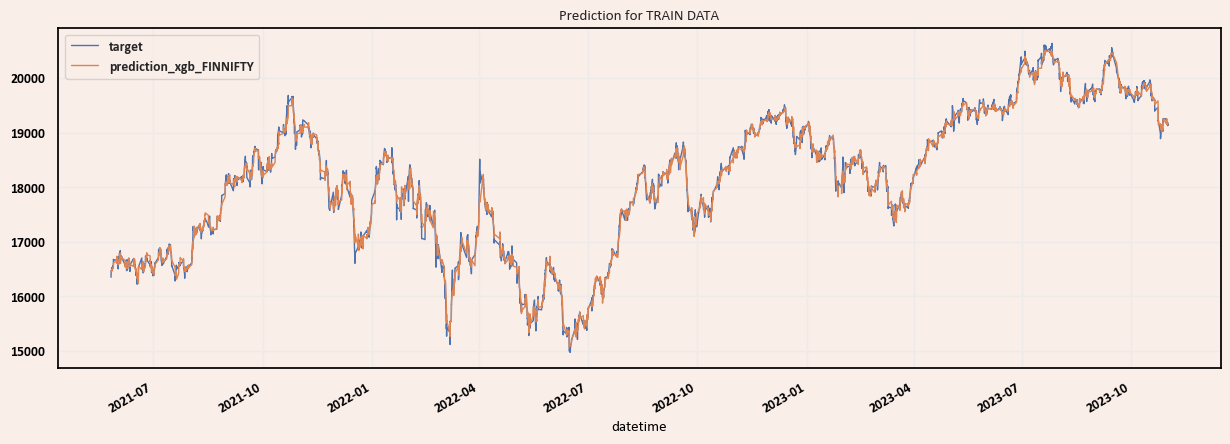

In [75]:
result_train = y[(y['datetime'] <= validation_cutoff)].copy()
result_train[f'prediction_xgb_{stock}'] = pred_train
plt.figure(figsize=(10,5))
result_train.set_index('datetime').plot()
plt.title(f"Prediction for TRAIN DATA")

Text(0.5, 1.0, 'Prediction for VALIDATION DATA')

<Figure size 1000x500 with 0 Axes>

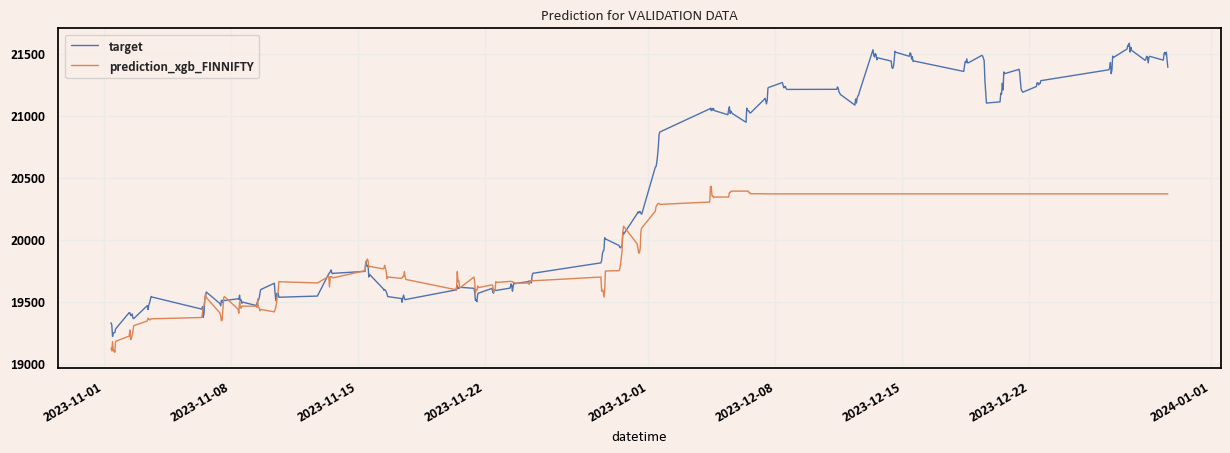

In [76]:
 #We have data from 2020-07-01 00:00:00
 #We have data till 2023-02-13 23:45:00

result_valid = y[(y['datetime'] > validation_cutoff) & (y['datetime'] <= test_cutoff)].copy()
result_valid[f'prediction_xgb_{stock}'] = pred_valid
plt.figure(figsize=(10,5))
result_valid.set_index('datetime').plot()
plt.title(f"Prediction for VALIDATION DATA")

Text(0.5, 1.0, 'Prediction for TEST')

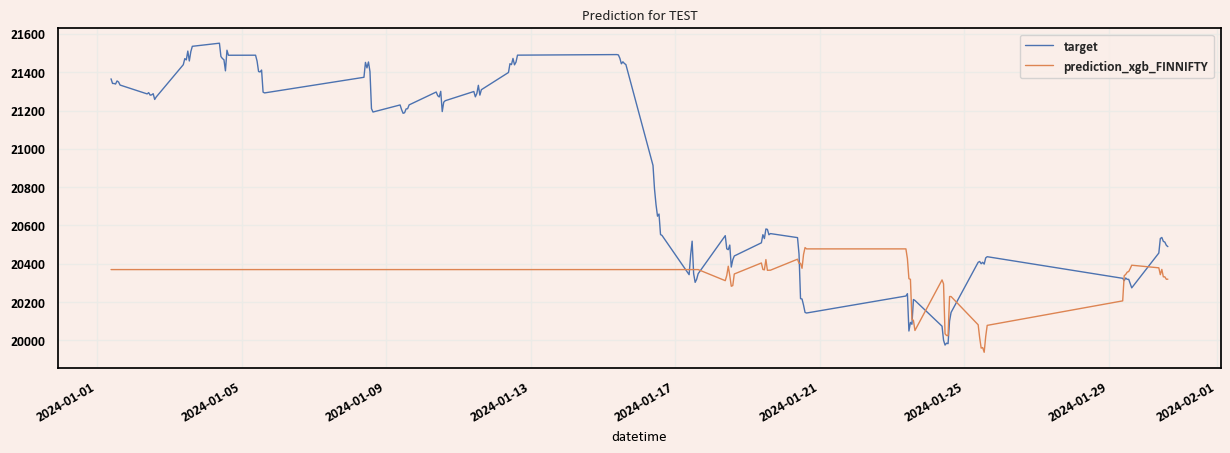

In [77]:

mask = (result.datetime > test_cutoff)
result.loc[mask,:].set_index('datetime')
result.loc[mask,:].set_index('datetime').plot()
plt.title("Prediction for TEST")

#result.loc[mask,:].set_index('datetime')

## Find Last working and Next working DAY

In [124]:
holiday_list = ['2023-11-27', '2023-12-25']
#holiday_list = [x+' 00:00:00' for x in holiday_list]
#holiday_list = [datetime.strptime(x, '%Y-%m-%d') for x in holiday_list]

In [125]:
def check_is_inbetween_market_time(test_date):
    #----This block of code will check if we are running code before 3:30PM then it will not take today's data----
    if test_date not in holiday_list and test_date.weekday() not in [5, 6]:    
        now = datetime.now()
        today15_30 = now.replace(hour=15, minute=30, second=0)
        if now <= today15_30:
            test_date = test_date-timedelta(days=1)
    return test_date

check_is_inbetween_market_time(datetime.now())

datetime.datetime(2024, 1, 31, 7, 5, 58, 784192)

In [126]:
def find_last_working_day(test_date):
    
    if test_date.weekday() == 0:
        diff = 3
    elif test_date.weekday() == 6:
        diff = 2
    else :
        diff = 1

    res = test_date - timedelta(days=diff)
    
    while str(res) in holiday_list:
        res = res - timedelta(days=1)
        
    if res.weekday() in [0, 6]:
        res = find_last_working_day(res) # Recursive call beacuse 
        # may be we have today tuesday and on monday we have holiday
        # then without recursive call it will give sunday as last working day
        
    return res

find_last_working_day(datetime.now())

datetime.datetime(2024, 1, 31, 7, 5, 59, 574314)

In [127]:
def find_Next_working_day(test_date):
    
    if test_date.weekday() == 5:
        add = 2
    elif test_date.weekday() == 6:
        add = 1
    else :
        add = 0

    res = test_date + timedelta(days=add)
    
    while str(res) in holiday_list:
        res = res + timedelta(days=1)
        
    if res.weekday() in [5, 6]:
        res = find_Next_working_day(res) # Recursive call
        
    return res

find_Next_working_day(datetime.now())

datetime.datetime(2024, 2, 1, 7, 6, 0, 417827)

In [128]:
#test_date = datetime(2023, 11, 16)
test_date = dt.date.today()
test_date = check_is_inbetween_market_time(test_date)


last_working = find_last_working_day(test_date)
next_working = find_Next_working_day(test_date)

print(f"Input Date:{test_date} ~~~~ Last Working date:{str(last_working)}")
print(f"Input Date:{test_date} ~~~~ NEXT Working date:{str(next_working)}")

Input Date:2024-01-31 ~~~~ Last Working date:2024-01-30
Input Date:2024-01-31 ~~~~ NEXT Working date:2024-01-31


In [82]:
# result.datetime.to_numpy()[0] > dt.date.today()

In [83]:
#(result.datetime > pd.Timestamp.today())
#result.datetime > np.datetime64('today', 'D')

In [84]:
# ajj = dt.date.today()
# #ajj = np.datetime64('today', 'D')
# end_date = find_last_working_day(ajj)
# np.datetime64(end_date)

## Peformance for LAST working DAY

Forcast for: 2024-02-01
Basicall for today's prediction, Datetime will be yesterday's only as per logic As we have shifted target by 1, so for Date 15th prediction Datetime will show 14th


,target,prediction_xgb_FINNIFTY
datetime,,


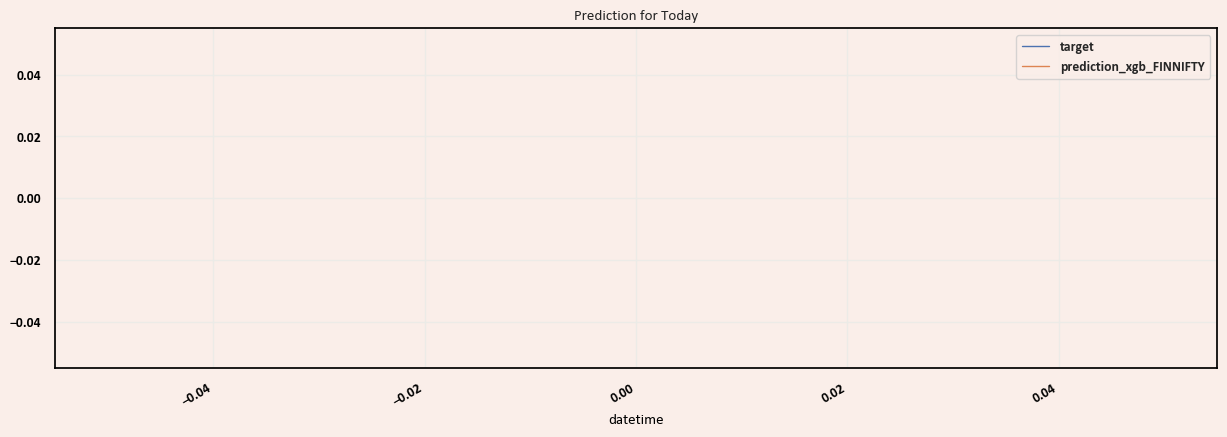

In [85]:
ajj = dt.date.today() # I guess its in python only
#ajj = np.datetime64('today', 'D') # How we define in numpy
#ajj = pd.Timestamp.today()  # How we define in pandas

end_date = find_last_working_day(ajj)



#---Below will work for weekdays as well--------------
#----- to run code for Saturday and Sunday------------------
if ajj.weekday() == 5:
    ajj = ajj - timedelta(days=1)
    end_date = end_date - timedelta(days=1)

if ajj.weekday() == 6:
    ajj = ajj - timedelta(days=2)
    end_date = end_date - timedelta(days=2)
#----- End of to run code for Saturday and Sunday------------------
    
    
    
    

print(f"Forcast for: {ajj}")
print("Basicall for today's prediction, Datetime will be yesterday's only as per logic As we have shifted target by 1, so for Date 15th prediction Datetime will show 14th")
mask = (result.datetime > np.datetime64(end_date))
#mask = (result.datetime >= end_date)

result.loc[mask,:].set_index('datetime').plot()
plt.title("Prediction for Today")

result.loc[mask,:].set_index('datetime')

In [86]:
# # JUST ANOTHER WAY FOR ABOVE CODE

# end_date = dt.date.today()
# days_sub = 1 # XXXXXXXXXXXXXXXXXXXXXXX
# end_date = dt.datetime(end_date.year, end_date.month, end_date.day-days_sub, 9, 15)

# print(f"Forcast Date~~~~~{end_date}")

# mask = (result.datetime >= end_date)
# result.loc[mask,:].set_index('datetime').plot()
# plt.title("Prediction for Today")


# result.loc[mask,:].set_index('datetime')

In [87]:
def feature_importance(features, importance_score):
    importances = pd.DataFrame(data={
        'Attribute': features,
        'Importance': importance_score
    })
    importances = importances.sort_values(by='Importance', ascending=False)
    plt.bar(x=importances['Attribute'], height=importances['Importance'])
    plt.title('Feature importances obtained from coefficients')
    plt.xticks(rotation='vertical')
    plt.show()

In [88]:
print(X_train.columns.shape)
print(xgbreg.feature_importances_.shape)

(130,)
(16,)


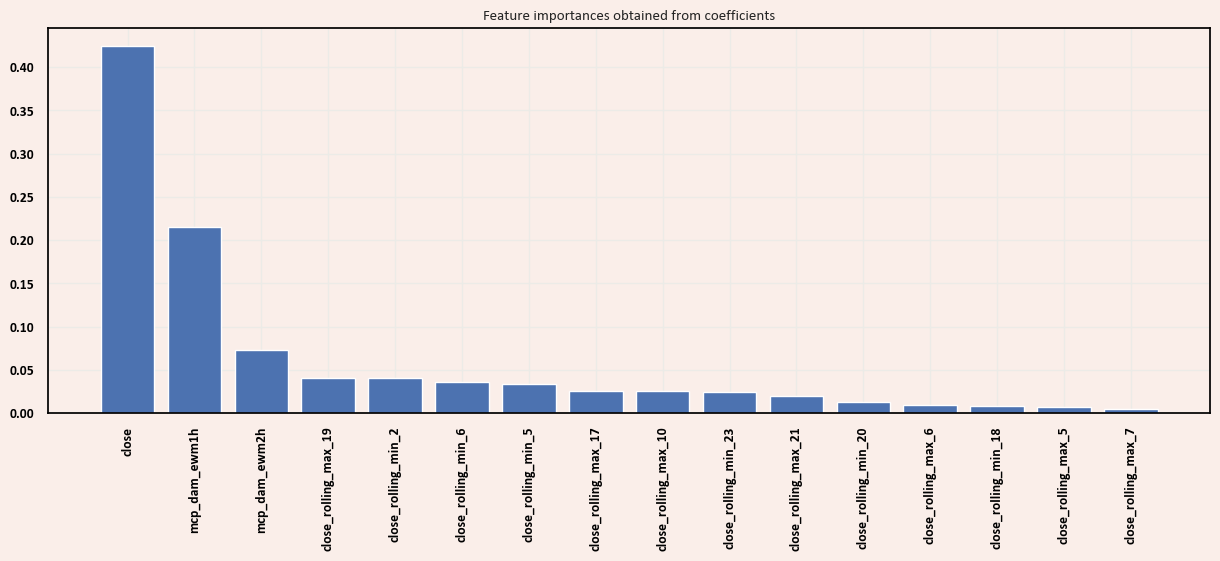

In [89]:
feature_importance(best_features, xgbreg.feature_importances_)

## Final Model saving

In [90]:
# Saving the final Best features used by model
model_name = f"{stock}_best_features_XGBoost"
pickle.dump(best_features, open(f'03_Saved_Model/{model_name}.pkl', 'wb'))

In [91]:
# Saving the final model
model_name = f"{stock}_XGBoost"
pickle.dump(xgbreg, open(f'03_Saved_Model/{model_name}.pkl', 'wb'))

# ********Final Prediction (XGBoost)********

In [92]:
test_date = dt.date.today()
next_working = find_Next_working_day(test_date)
next_working = dt.datetime(next_working.year, next_working.month, next_working.day, 9, 15)
next_working

datetime.datetime(2024, 2, 1, 9, 15)

In [93]:
pred_day_ahead = pd.DataFrame(pd.date_range(start=next_working, periods=target_ahead_timeblocks, freq=frequency_in_mins), columns=['datetime']) #inclusive in the newer version
pred_day_ahead.set_index("datetime", inplace = True)
pred_day_ahead[f'prediction_xgb_{stock}'] = xgbreg.predict(next_day_df_prediction[best_features])
pred_day_ahead

,prediction_xgb_FINNIFTY
datetime,
2024-02-01 09:15:00,20398.105469
2024-02-01 10:15:00,20393.994141
2024-02-01 11:15:00,20424.884766
2024-02-01 12:15:00,20425.242188
2024-02-01 13:15:00,20438.357422
2024-02-01 14:15:00,20434.693359
2024-02-01 15:15:00,20364.007812


In [94]:
# pred_day_ahead = pd.DataFrame()
# pred_day_ahead.index = next_day_df_prediction['datetime']
# pred_day_ahead[f'prediction_xgb_{stock}'] = xgbreg.predict(next_day_df_prediction[best_features])
# pred_day_ahead

# Model-2 - Logistic Regression

In [95]:
#We Have the following:
#X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y, validation_cutoff, test_cutoff)

### Multicollinearity check by VIF score

In [96]:
# """
# Let's now keep on removing features till we have a feature with vif<5
# """
# import statsmodels.api as sm

# scaler_vif = StandardScaler()
# X_train_vif_s = scaler_vif.fit_transform(X_train)





# vif_thr = 20
# #r2_thr = 0.85
# i = 0
# feats_removed = []

# cols2=X.columns

# while True:
    
#     vif = pd.DataFrame()
#     X_t = pd.DataFrame(X_train_vif_s, columns=X.columns)[cols2]
#     vif['Features'] = cols2
#     vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
#     vif['VIF'] = round(vif['VIF'], 2)
#     vif = vif.sort_values(by = "VIF", ascending = False)

#   #cols2 = vif["Features"][1:].values
#     cols2 = vif["Features"][i:].values
#     X2 = pd.DataFrame(X_train_vif_s, columns=X.columns)[cols2]

#     #X2_sm = sm.add_constant(X2)  #Statmodels default is without intercept, to add intercept we need to add constant
#     #sm_model = sm.OLS(list(y_train), X2_sm).fit()
  
#     print('Feature no. ', i)
#     print('VIF Score ', vif.iloc[i]['VIF'])
#     #print('Adjusted R2 ', sm_model.rsquared_adj)


#     #if (vif.iloc[i]['VIF'] < vif_thr) or (sm_model.rsquared_adj > r2_thr):
#     if (vif.iloc[i]['VIF'] < vif_thr):
#         print('Reached threshold')
#         print('Highest vif:',vif.iloc[i])
#         #print('Current adj.R2',sm_model.rsquared_adj)
#         print('Features removed:', i)
#         print('List of features removed:', feats_removed)
#         break
#     feats_removed.append(vif.iloc[i]['Features'])
#     i += 1

In [97]:
X_train

,close,hour,dom,month,dow,doy,woy,week_number,friday,covid,...,close_rolling_max_28,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close
0,16421.25,14,26,5,2,146,21,21,0.0,1.0,...,16453.40,15828.90,16276.832759,16453.40,15828.90,-3.80,0.75,-7.25,119.10,152.40
1,16414.25,15,26,5,2,146,21,21,0.0,1.0,...,16453.40,15828.90,16292.475862,16453.40,15828.90,-7.00,-3.80,0.75,-7.25,98.25
2,16413.30,16,26,5,2,146,21,21,0.0,1.0,...,16453.40,15832.40,16308.510345,16453.40,15828.90,-0.95,-7.00,-3.80,0.75,85.40
3,16348.10,10,27,5,3,147,21,21,0.0,1.0,...,16453.40,16109.15,16328.662069,16453.40,15832.40,-65.20,-0.95,-7.00,-3.80,35.65
4,16352.30,11,27,5,3,147,21,21,0.0,1.0,...,16453.40,16113.90,16346.444828,16453.40,16109.15,4.20,-65.20,-0.95,-7.00,-79.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4214,19220.20,12,31,10,1,304,44,44,0.0,0.0,...,19355.45,18887.15,19128.250000,19419.95,18887.15,-29.45,4.45,-9.20,15.95,31.95
4215,19252.40,13,31,10,1,304,44,44,0.0,0.0,...,19281.60,18887.15,19121.362069,19355.45,18887.15,32.20,-29.45,4.45,-9.20,28.45
4216,19247.55,14,31,10,1,304,44,44,0.0,0.0,...,19281.60,18887.15,19117.808621,19281.60,18887.15,-4.85,32.20,-29.45,4.45,56.35
4217,19201.70,15,31,10,1,304,44,44,0.0,0.0,...,19254.40,18887.15,19119.200000,19281.60,18887.15,-45.85,-4.85,32.20,-29.45,-36.75


In [98]:
11638-(11056+441+141)

0

## Scaling

In [99]:
print(X_train.columns.tolist())

['close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy', 'week_number', 'friday', 'covid', 'covid_first_wave', 'covid_second_wave', 'cos_hour', 'sin_hour', 'cos_dow', 'sin_dow', 'cos_doy', 'sin_doy', 'lag1h', 'lag2h', 'lag4h', 'lag6h', 'lag12h', 'lag1d', 'lag2d', 'lag3d', 'lag4d', 'lag5d', 'lag6d', 'lag7d', 'mcp_dam_ewm1h', 'mcp_dam_ewm2h', 'mcp_dam_ewm3h', 'mcp_dam_ewm4h', 'mcp_dam_ewm6h', 'mcp_dam_ewm8h', 'mcp_dam_ewm12h', 'mcp_dam_ewm24h', 'close_rolling_mean_1', 'close_rolling_max_1', 'close_rolling_min_1', 'close_rolling_mean_2', 'close_rolling_max_2', 'close_rolling_min_2', 'close_rolling_mean_3', 'close_rolling_max_3', 'close_rolling_min_3', 'close_rolling_mean_4', 'close_rolling_max_4', 'close_rolling_min_4', 'close_rolling_mean_5', 'close_rolling_max_5', 'close_rolling_min_5', 'close_rolling_mean_6', 'close_rolling_max_6', 'close_rolling_min_6', 'close_rolling_mean_7', 'close_rolling_max_7', 'close_rolling_min_7', 'close_rolling_mean_8', 'close_rolling_max_8', 'close_rolling_min

In [100]:
len(X_train.columns)

130

In [101]:
# rescale the features
#scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid) # Transform to Validation data as well
X_test_scaled = scaler.transform(X_test) # Transform to test data as well

In [102]:
print('Train =', X_train_scaled.shape, y_train.shape)
print('Train =', X_valid_scaled.shape, y_valid.shape)
print('Test =', X_test_scaled.shape, y_test.shape)

Train = (4219, 130) (4219, 1)
Train = (281, 130) (281, 1)
Test = (147, 130) (147, 1)


In [103]:
X_train.columns

Index(['close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy', 'week_number',
       'friday', 'covid',
       ...
       'close_rolling_max_28', 'close_rolling_min_28', 'close_rolling_mean_29',
       'close_rolling_max_29', 'close_rolling_min_29', 'ramp1', 'ramp2',
       'ramp3', 'ramp4', 'ramp_close'],
      dtype='object', length=130)

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

reg_model = LinearRegression(n_jobs=-1)
reg_model.fit(X_train_scaled, y_train)

# Make predictions using the testing set
y_train_pred = reg_model.predict(X_train_scaled)
X_valid_pred = reg_model.predict(X_valid_scaled)
y_test_pred = reg_model.predict(X_test_scaled)


In [105]:
# Making predictions with the tuned model
pred_train = reg_model.predict(X_train_scaled)
pred_valid = reg_model.predict(X_valid_scaled)
pred_test = reg_model.predict(X_test_scaled)

In [106]:
# Evaluate model accuracy 
from sklearn.metrics import mean_squared_error
print(f"Train MSE: {mean_squared_error(y_train['target'],pred_train)}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train['target'],pred_train))}")
print(f"valid MSE: {mean_squared_error(y_valid['target'],pred_valid)}")
print(f"valid RMSE: {np.sqrt(mean_squared_error(y_valid['target'],pred_valid))}")
print(f"Test MSE: {mean_squared_error(y_test['target'],pred_test)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test['target'],pred_test))}")

Train MSE: 34716.23755104056
Train RMSE: 186.32293887506327
valid MSE: 30937.262302824398
valid RMSE: 175.88991529597254
Test MSE: 53302.83826834455
Test RMSE: 230.87407448291927


In [107]:
#result = y[y['datetime'] > test_cutoff].copy()
result[f'prediction_LR_{stock}'] = pred_test
result.tail(10)

,datetime,target,prediction_xgb_FINNIFTY,prediction_LR_FINNIFTY
4637,2024-01-29 13:15:00,20318.45,20359.152344,20349.426550
4638,2024-01-29 14:15:00,20296.25,20374.447266,20398.982314
4639,2024-01-29 15:15:00,20273.85,20392.097656,20425.517258
4640,2024-01-30 09:15:00,20455.70,20378.505859,20233.786115
4641,2024-01-30 10:15:00,20531.60,20342.687500,20212.885219
4642,2024-01-30 11:15:00,20536.95,20370.136719,20254.410876
4643,2024-01-30 12:15:00,20516.60,20331.458984,20256.677999
4644,2024-01-30 13:15:00,20512.75,20331.458984,20284.326621
4645,2024-01-30 14:15:00,20496.05,20318.625000,20279.980108
4646,2024-01-30 15:15:00,20489.10,20319.257812,20271.998269


Text(0.5, 1.0, 'Prediction for TRAIN DATA')

<Figure size 1000x500 with 0 Axes>

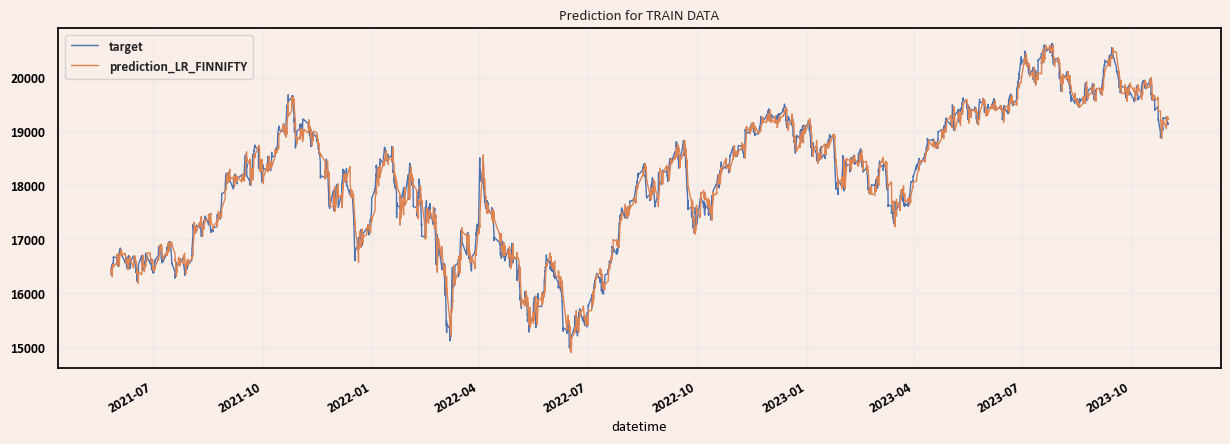

In [108]:
result_train = y[(y['datetime'] <= validation_cutoff)].copy()
result_train[f'prediction_LR_{stock}'] = pred_train
plt.figure(figsize=(10,5))
result_train.set_index('datetime').plot()
plt.title(f"Prediction for TRAIN DATA")

Text(0.5, 1.0, 'Prediction for VALIDATION DATA')

<Figure size 1000x500 with 0 Axes>

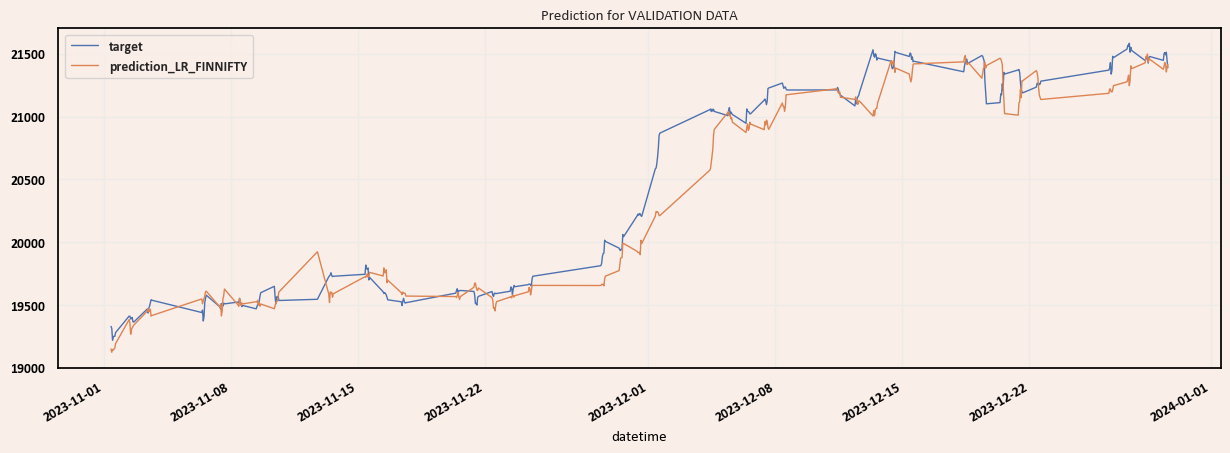

In [109]:
result_valid = y[(y['datetime'] > validation_cutoff) & (y['datetime'] <= test_cutoff)].copy()
result_valid[f'prediction_LR_{stock}'] = pred_valid
plt.figure(figsize=(10,5))
result_valid.set_index('datetime').plot()
plt.title(f"Prediction for VALIDATION DATA")

Text(0.5, 1.0, 'Prediction for TEST')

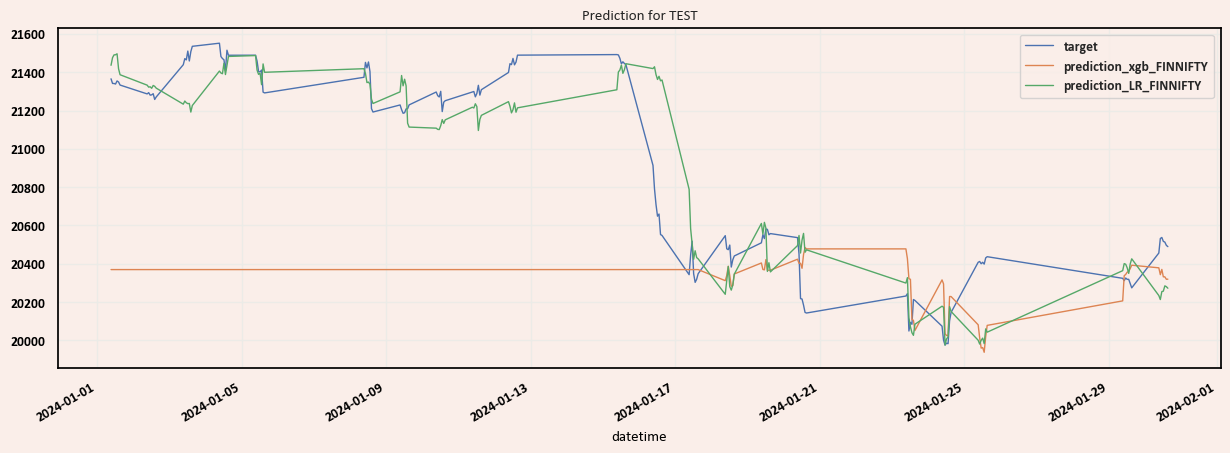

In [110]:
mask = (result.datetime > test_cutoff)
result.loc[mask,:].set_index('datetime')
result.loc[mask,:].set_index('datetime').plot()
plt.title("Prediction for TEST")

Forcast for: 2024-02-01
Basicall for today's prediction, Datetime will be yesterday's only as per logic As we have shifted target by 1, so for Date 15th prediction Datetime will show 14th


,target,prediction_xgb_FINNIFTY,prediction_LR_FINNIFTY
datetime,,,


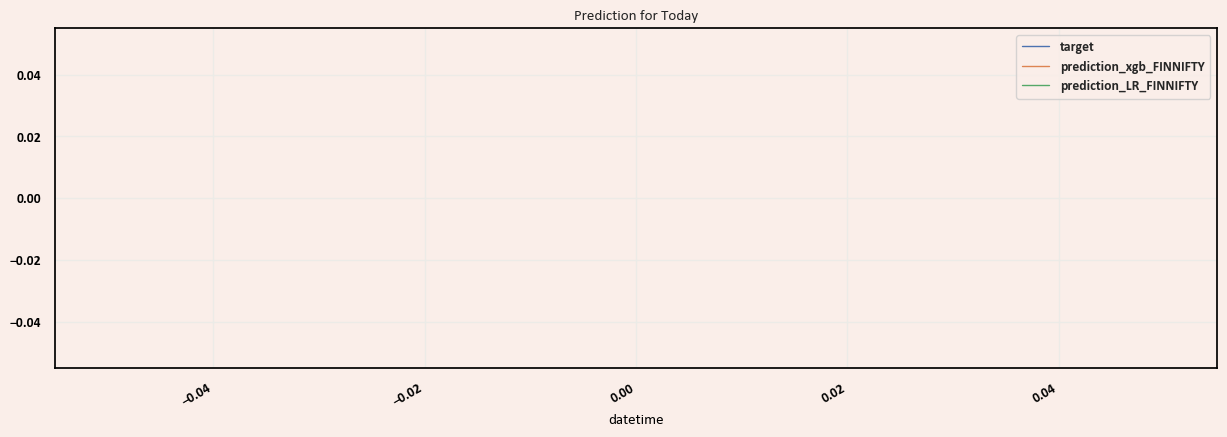

In [111]:
print(f"Forcast for: {ajj}")
print("Basicall for today's prediction, Datetime will be yesterday's only as per logic As we have shifted target by 1, so for Date 15th prediction Datetime will show 14th")

mask = (result.datetime > np.datetime64(end_date))
#mask = (result.datetime >= end_date)

result.loc[mask,:].set_index('datetime').plot()
plt.title("Prediction for Today")

final_prediction_df = result.loc[mask,:].set_index('datetime').copy()
final_prediction_df

## Feature Importance checking

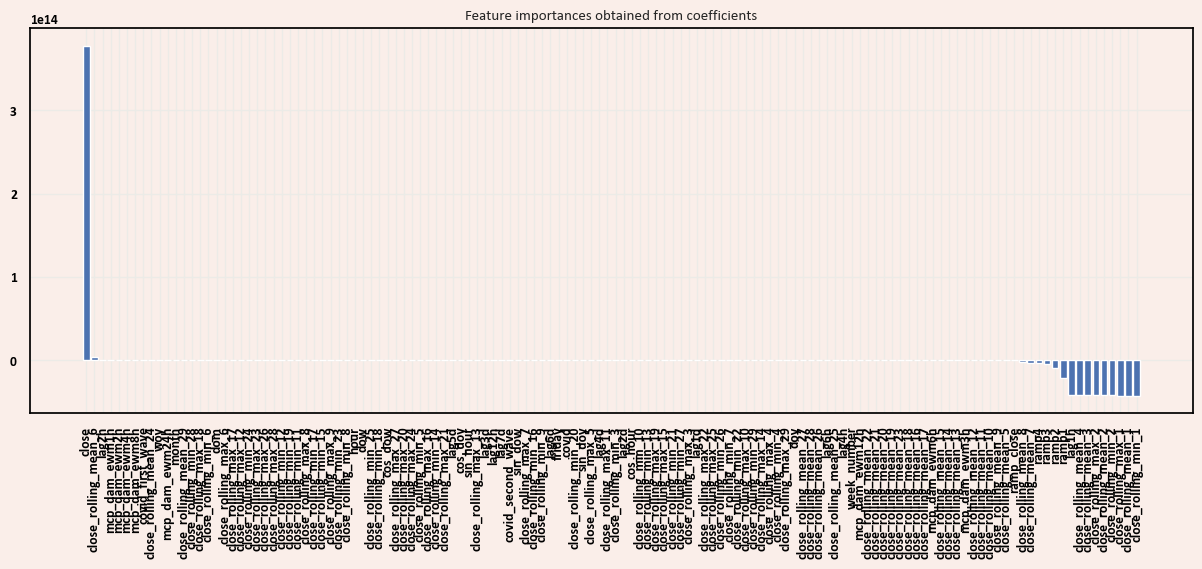

In [112]:
feature_importance(X_train.columns, reg_model.coef_[0])

## Final Model saving

In [113]:
# Saving the final scaler model
model_name = f"{stock}_scaler_LR"
pickle.dump(scaler, open(f'03_Saved_Model/{model_name}.pkl', 'wb'))

In [114]:
# Saving the final model
model_name = f"{stock}_LR"
pickle.dump(reg_model, open(f'03_Saved_Model/{model_name}.pkl', 'wb'))

In [115]:
# Checking Current day Prediction of stock along with name
# Keep it mind that this is not final prediction for next day

final_prediction_df.insert(0,'Stock', stock)  # This is code to add column at specific location
final_prediction_df

,Stock,target,prediction_xgb_FINNIFTY,prediction_LR_FINNIFTY
datetime,,,,


# ********Final Prediction (Linear Regression)********

In [116]:
tobe_used_features = get_final_features(next_day_df_prediction)
tobe_used_features.remove('datetime') # Remove DateTime as well as we dont need it
print(len(tobe_used_features))

130


In [117]:
next_day_df_prediction_LR = next_day_df_prediction[tobe_used_features]
#print(next_day_df_prediction_LR.columns.tolist())

next_day_df_prediction_LR_scaled = scaler.transform(next_day_df_prediction_LR) # Scaled the DF

pred_day_ahead[f'prediction_LR_{stock}'] = reg_model.predict(next_day_df_prediction_LR_scaled)
pred_day_ahead

,prediction_xgb_FINNIFTY,prediction_LR_FINNIFTY
datetime,,
2024-02-01 09:15:00,20398.105469,20440.205229
2024-02-01 10:15:00,20393.994141,20511.182924
2024-02-01 11:15:00,20424.884766,20546.857694
2024-02-01 12:15:00,20425.242188,20508.147729
2024-02-01 13:15:00,20438.357422,20484.287781
2024-02-01 14:15:00,20434.693359,20481.651184
2024-02-01 15:15:00,20364.007812,20490.904364


In [118]:
final_prediction_df_excel = pred_day_ahead.copy()

In [119]:
import xlwings as xw

df_date_check = final_prediction_df_excel.index[0]

wb = xw.Book('AngelOne_Option.xlsx')
exl_ML_prediction = wb.sheets['ML_prediction']


a = exl_ML_prediction[11,2].value
if a == final_prediction_df_excel.index[0]:  # we check if dates are already there and 
                                             # if they are for correct forecasrt day else delete them
    print("Data Appended")
    for c in range(2,300):
        check_blank = exl_ML_prediction[10,c].value
        if check_blank is None:
            exl_ML_prediction[10,c].options(pd.DataFrame, header=1, index=False, expand='table').value = final_prediction_df_excel
            break          
else:
    print("Brand New Data")
    exl_ML_prediction.range("B10:HQ200").clear_contents()
    exl_ML_prediction["C11"].options(pd.DataFrame, header=1, index=True, expand='table').value = final_prediction_df_excel
    
    

Brand New Data


In [120]:
print("All done and push a little more for more accuracy")

All done and push a little more for more accuracy
